In [1]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from numpy import load
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from numpy import linalg as la
from matplotlib import pyplot
import os
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
# face detection for the 5 Celebrity Faces Dataset
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
 
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces
 
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)
 
# load train dataset
trainX, trainy = load_dataset('data/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('data/val/')
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

In [2]:
# load the face dataset
data = load('notebooks/5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [5]:
# load the facenet model
model = load_model('../keras-facenet/model/facenet_keras.h5')
print('Loaded Model')

Instructions for updating:
Colocations handled automatically by placer.
Loaded Model


C:\Users\lenovo\Anaconda3\envs\PythonCPU\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
 
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 
# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# load the facenet model
model = load_model('keras-facenet/model/facenet_keras.h5')
print('Loaded Model')

# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (91, 160, 160, 3) (91,) (25, 160, 160, 3) (25,)
Loaded Model
(91, 128)
(25, 128)


In [9]:
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=91, test=25


In [21]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

trainy.shape

(91,)

In [76]:
# Verifying identity

faces = trainX
embedding = trainX.flatten()
D = []
pairs = []
d = 0.7
Psame = []
Pdiff = []
TA = []
FA = []

# Selecting all possible pairs and computing L2-distance
for i in range(len(faces)):
    for j in range(len(faces)):
        selection = np.random.choice(embedding, size=128, replace=False)
        l2 = la.norm(selection[0] - selection[1])**2
        pairs.append(selection)
        D.append(l2)
        if l2 < d:
            Psame.append(selection)
        else:
            Pdiff.append(selection)
                
# Plotting each pair in Psame and Pdiff

# Computing Metrics

# True Accepts
for s in range(len(Psame)):
         if D[s] <= d:
                TA.append(Psame[s])
# False Accepts
for m in range(len(Pdiff)):
         if D[m] <= d:
                FA.append(Pdiff[m])  
                
# VAL and FAR rates
Psame_a = np.array(Psame)
Pdiff_a = np.array(Pdiff)
TA_a = np.array(TA)
FA_a = np.array(FA)
Ps, Pd = np.absolute(Psame_a), np.absolute(Pdiff_a)
true, false = np.absolute(TA_a), np.absolute(FA_a)

VAL = true/Ps
FAR = false/Pd

# Plotting VAL vs FAR

# Sensitivity Analysis - ROC Curves

In [22]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("5-celebrity-faces-dataset.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/model/facenet_keras.h5"
model = load_model(path_to_model)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [23]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("5-celebrity-faces-dataset-norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

Dataset: train=93, test=25
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'mindy_k

In [24]:
# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1 

# new_emb = [0.42, -0.11, ..., 0], [1.22, -2.11, ..., 24] 
# OBS: - the last number in the array (new_emb) is the index of the img in their raw dataset (the img dataset)


#print(raw_trainX[0])
#print(trainX2[0][-1])
#print(raw_trainX[int(trainX2[0][-1])])
#plt.imshow(raw_trainX[int(trainX2[0][-1])])

# Real Metric Obtention

Pairs: 4278
Psame: 3073
Pdiff: 39707
Ground Truth Threshold: 0.1
Psame: 3073
Pdiff: 39707
TA: 10
FA: 0
VAL: 0.0032541490400260333
FAR: 0.0
Ground Truth Threshold: 0.2
Psame: 3073
Pdiff: 39707
TA: 83
FA: 7
VAL: 0.027009437032216074
FAR: 0.00017629133402170902
Ground Truth Threshold: 0.3
Psame: 3073
Pdiff: 39707
TA: 460
FA: 90
VAL: 0.14969085584119754
FAR: 0.0022666028659934015
Ground Truth Threshold: 0.4
Psame: 3073
Pdiff: 39707
TA: 1537
FA: 473
VAL: 0.5001627074520013
FAR: 0.011912257284609767
Ground Truth Threshold: 0.5
Psame: 3073
Pdiff: 39707
TA: 3178
FA: 1232
VAL: 1.0341685649202734
FAR: 0.03102727478782079
Ground Truth Threshold: 0.6
Psame: 3073
Pdiff: 39707
TA: 5319
FA: 2491
VAL: 1.730881874389847
FAR: 0.0627345304354396
Ground Truth Threshold: 0.7
Psame: 3073
Pdiff: 39707
TA: 7868
FA: 4362
VAL: 2.560364464692483
FAR: 0.10985468557181353
Ground Truth Threshold: 0.8
Psame: 3073
Pdiff: 39707
TA: 10735
FA: 6975
VAL: 3.4933289944679466
FAR: 0.17566172211448863
Ground Truth Threshold:

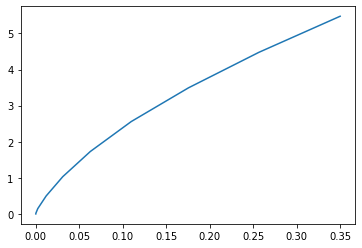

In [73]:
# Verifying identity

# 1) Pair formattion

how_many = len(trainX2) # how_many = 93

# Formation of pairs (everyone with everyone)

pairs = list() 
# pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

for i in range(how_many):
    for j in range(i+1, how_many):
        pair = list()
        img_i = trainX2[i][0:-1]
        label_i = trainX2[i][-1]
        img_j = trainX2[j][0:-1]
        label_j = trainX2[j][-1]
        pair.append(img_i)
        pair.append(img_j)
        pair.append(label_i)
        pair.append(label_j)
        pairs.append(pair)

# 2) Pair comparison

threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Psame = list()
Pdiff = list()
for t in range(len(threshold)):
    #print("Threshold: " + str(threshold[t]))
    for pair in pairs:
        norm = np.linalg.norm(pair[0] - pair[1])**2
        comparison = [pair[0], pair[1], pair[2], pair[3], norm]
        if norm < threshold[t]:
            Psame.append(comparison)
        else:
            Pdiff.append(comparison)

print("Pairs: " + str(len(pairs)))
print("Psame: " + str(len(Psame)))
print("Pdiff: " + str(len(Pdiff)))

# 3) VAL and FAR rates

TA = [] 
ta_d = []
FA = []
fa_d = []
VAL = []
FAR = []

for t in range(len(threshold)):
    for pair in Psame:
        if pair[-1] <= threshold[t]:
            TA.append(pair)
    ta_counter = len(TA)
    #print(ta_counter)
    ta_d.append(ta_counter) 
    for pair in Pdiff:
        if pair[-1] <= threshold[t]:
            FA.append(pair)
    fa_counter = len(FA)
    fa_d.append(fa_counter)
    #print(fa_counter)
    val = ta_counter/len(Psame)
    #print(val)
    VAL.append(val)
    far = fa_counter/len(Pdiff)
    #print(far)
    FAR.append(far)
    print("Ground Truth Threshold: " + str(threshold[t]))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))
    print("TA: " + str(len(TA)))
    print("FA: " + str(len(FA)))
    print("VAL: " + str(VAL[t]))
    print("FAR: " + str(FAR[t]))
    
VAL = np.asarray(VAL)
FAR = np.asarray(FAR)
print("VAL")
print(VAL)
print("FAR")
print(FAR)

plt.figure()
plt.plot(FAR, VAL)
plt.show()

# Ignore the below code 

In [46]:
# Verifying identity

# 1) Pair formattion

how_many = len(trainX2) # how_many = 93

# Formation of pairs (everyone with everyone)

pairs = list()
pairs_array = list()
# pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i


for i in range(how_many):
    for j in range(i+1, how_many):
        pair = list()
        pair_array = list()
        #print("(" + str(i) + "," + str(j) + ")")
        img_i = trainX2[i][0:-1]
        label_i = trainX2[i][-1]
        img_j = trainX2[j][0:-1]
        label_j = trainX2[j][-1]
        pair.append(img_i)
        pair.append(img_j)
        pair.append(label_i)
        pair.append(label_j)
        pairs.append(pair)
        pair_array.append(img_i)
        pair_array.append(img_j)
        pair_array = np.asarray(pair_array)
        pairs_array.append(pair_array)

pairs_array = np.asarray(pairs_array)
print(type(pair_array))
print(pair_array)
print(pairs_array)
        
#print(img_i.shape)
#print(img_j.shape)
#print(label_i)
#print(label_j)
#print(len(pairs)) - len(pairs) = 4278

# 2) Pair comparison

Psame = list()
Pdiff = list()

threshold = 0.7
print("Threshold: " + str(threshold))

for pair in pairs:
    #print(pair[0])
    norm = np.linalg.norm(pair[0] - pair[1])**2
    comparison = [pair[0], pair[1], pair[2], pair[3], norm] 
    temp_pair = list()
    if norm < threshold:
        Psame.append(comparison)   
    else:
        Pdiff.append(comparison)


        



#print("Psame")
#print(Psame)
        
# comparison = [img_i, img_j, label_i, label_j, norm]
        
#print(pair[0])
#print(pair[1])
#print(pair[2])
#print(pair[3])
print("Pairs: " + str(len(pairs)))
print("Psame: " + str(len(Psame)))
print("Pdiff: " + str(len(Pdiff)))
#print(Psame[0])
#plt.imshow(raw_trainX[int(pair[2])])
#plt.show()
#plt.imshow(raw_trainX[int(pair[3])])
#plt.show()

# 3) VAL and FAR rates

TA = list()
FA = list()

for pair in Psame:
    temp_pair = list()
    if pair[-1] <= threshold:
        TA.append(pair)    

for pair in Pdiff:
    if pair[-1] <= threshold:
        FA.append(pair)
        
        
VAL = len(TA)/len(Psame)
FAR = len(FA)/len(Pdiff)

print("Psame: " + str(len(Psame)))
print("Pdiff: " + str(len(Pdiff)))
print("TA: " + str(len(TA)))
print("FA: " + str(len(FA)))
print("VAL: " + str(VAL))
print("FAR: " + str(FAR))

<class 'numpy.ndarray'>
[[ 0.03452708  0.02085726  0.06873133 -0.1339837   0.00444684  0.21712534
  -0.03158263  0.16985597  0.03718495  0.02834802 -0.05139274 -0.01587825
  -0.05485891  0.20082571 -0.06922546  0.06133445 -0.00358644  0.02631376
   0.09828489 -0.08016484  0.04342474  0.04275707  0.07380775 -0.19897754
   0.10943013  0.06126194 -0.09198706  0.15958367  0.00570973 -0.06591595
  -0.05675248 -0.01902437  0.03467475 -0.0645306   0.08194473 -0.06513286
  -0.15883829  0.06943014 -0.04373506  0.11015569 -0.15588856 -0.08016086
   0.15320671  0.02113285 -0.06434432  0.00205116 -0.13906345  0.10719084
   0.02804775  0.00219212  0.09655808  0.11950017  0.1001913  -0.03843303
   0.05075664 -0.07373942 -0.02594322  0.06653889 -0.03934153 -0.09752115
  -0.10082169  0.09160816 -0.07998198  0.1348235   0.01312257 -0.15790275
  -0.06706235 -0.03466675  0.0600299  -0.10553679 -0.02635263  0.01947895
   0.04612778 -0.01481551 -0.07852283  0.12359741  0.11961913  0.00587463
   0.06792311 

In [157]:
def metric_obtention(trainX2, threshold_value):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)
    pairs = list() # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_{i,j} is the embedding of {i,j}

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    # 2) Pair comparison

    Psame = list()
    Pdiff = list()
    threshold = threshold_value
    print("Threshold: " + str(threshold))

    for pair in pairs:
        #print(pair[0])
        norm = np.linalg.norm(pair[0] - pair[1])**2
        comparison = [pair[0], pair[1], pair[2], pair[3], norm] 
        if norm < threshold:
            Psame.append(comparison)
        else:
            Pdiff.append(comparison)

    # comparison = [img_i_embedding, img_j_embedding, label_i, label_j, norm]

    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))

    # 3) VAL and FAR rates

    TA = list()
    FA = list()

    for pair in Psame:
        if pair[-1] <= threshold:
            TA.append(pair)

    for pair in Pdiff:
        if pair[-1] <= threshold:
            FA.append(pair)

    VAL = len(TA)/len(Psame)
    FAR = len(FA)/len(Pdiff)

    print("TA: " + str(len(TA)))
    print("FA: " + str(len(FA)))
    print("VAL: " + str(VAL))
    print("FAR: " + str(FAR))
    
    metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return    

Threshold: 0.7
Pairs: 4278
Psame: 350
Pdiff: 3928
TA: 350
FA: 0
VAL: 1.0
FAR: 0.0
---------------------
EXAMPLE PLOT


/home/jose/Documents/IPD441/Proyecto/rebuild/faces/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/jose/Documents/IPD441/Proyecto/rebuild/faces/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

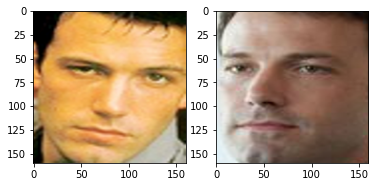

<Figure size 432x288 with 0 Axes>

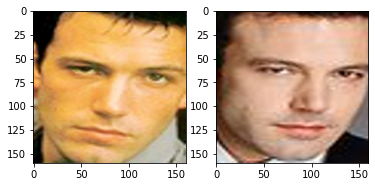

<Figure size 432x288 with 0 Axes>

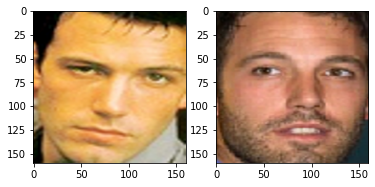

<Figure size 432x288 with 0 Axes>

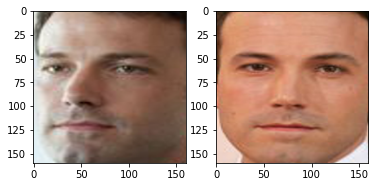

<Figure size 432x288 with 0 Axes>

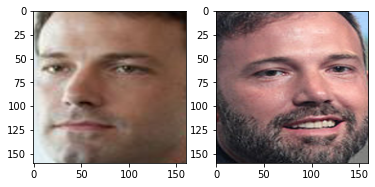

<Figure size 432x288 with 0 Axes>

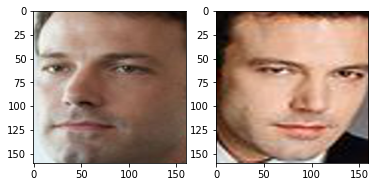

<Figure size 432x288 with 0 Axes>

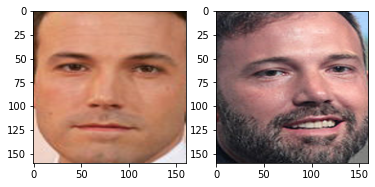

<Figure size 432x288 with 0 Axes>

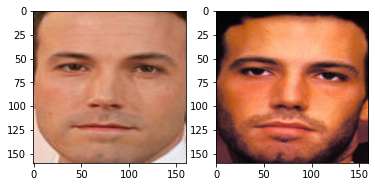

<Figure size 432x288 with 0 Axes>

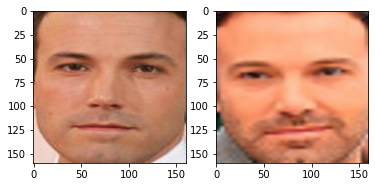

<Figure size 432x288 with 0 Axes>

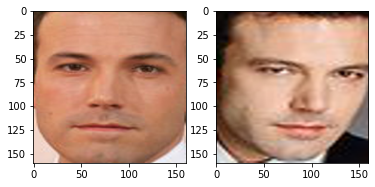

<Figure size 432x288 with 0 Axes>

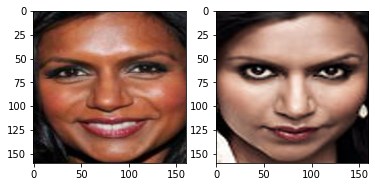

<Figure size 432x288 with 0 Axes>

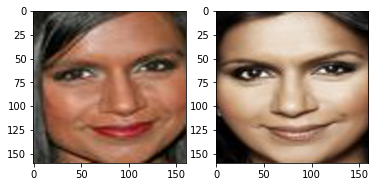

<Figure size 432x288 with 0 Axes>

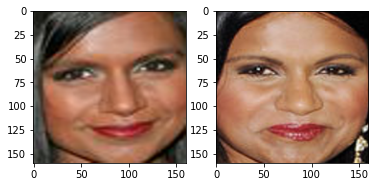

<Figure size 432x288 with 0 Axes>

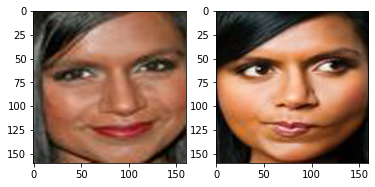

<Figure size 432x288 with 0 Axes>

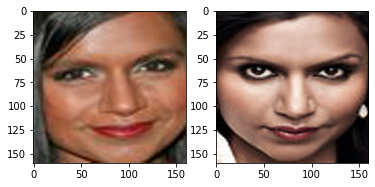

<Figure size 432x288 with 0 Axes>

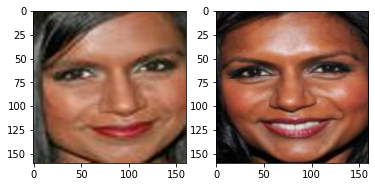

<Figure size 432x288 with 0 Axes>

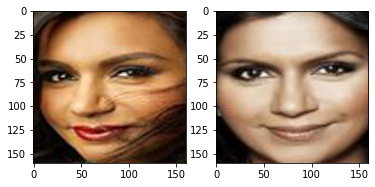

<Figure size 432x288 with 0 Axes>

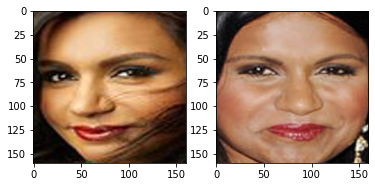

<Figure size 432x288 with 0 Axes>

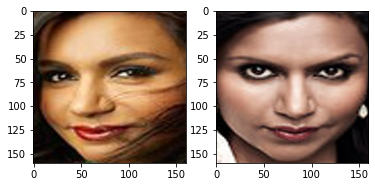

<Figure size 432x288 with 0 Axes>

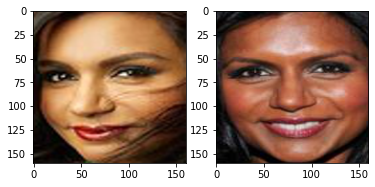

In [161]:
first_iteration = metric_obtention(trainX2, 0.7)
#second_iteration = metric_obtention(trainX2, 0.6)
#thirditeration = metric_obtention(trainX2, 0.5)
print("---------------------")
#plt.figure()
#f, axarr = plt.subplots(1,2)
#axarr[0].imshow(raw_trainX[int(first_iteration[1][50][2])])
#axarr[1].imshow(raw_trainX[int(first_iteration[1][50][3])])
    
face_pairs_plot(first_iteration, raw_trainX, 10)

print("EXAMPLE PLOT")

for i in range(10):
    plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(raw_trainX[int(first_iteration[1][-(i+10)][2])])
    axarr[1].imshow(raw_trainX[int(first_iteration[1][-(i+10)][3])])
    
    
#start = 1 # 0.1
#end = 15  # 1.5
#steps = 1 # 0.1
#from iter in range(start, end,)
#for i in range(start, end, steps):
    #iteration = metric_obtention(trainX2, 0.1*i)
    #print(0.1*i)

# 5-celebs - Default Model

In [2]:
data = np.load("5-celebrity-faces-dataset.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/model/facenet_keras.h5"
model = load_model(path_to_model)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [3]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("5-celebrity-faces-dataset.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/model/facenet_keras.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('5-celebrity-faces-dataset-norm.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
(93, 128)
(25, 128)


In [4]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("5-celebrity-faces-dataset-norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=93, test=25
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'mindy_k

In [6]:
def metric_obtention(trainX2):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)

    pairs = list() 
    # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    #print(img_i.shape)
    #print(img_j.shape)
    #print(label_i)
    #print(label_j)
    #print(len(pairs)) - len(pairs) = 4278

    # 2) Pair comparison

    #threshold = [0.2, 0.5, 0.9]
    threshold = np.linspace(0.1, 0.9, num=9, endpoint=True, retstep=False, dtype=float, axis=0)
    Psame = list()
    Pdiff = list()
    for t in range(len(threshold)):
        #print("Threshold: " + str(threshold[t]))
        for pair in pairs:
            norm = np.linalg.norm(pair[0] - pair[1])**2
            comparison = [pair[0], pair[1], pair[2], pair[3], norm]
            if norm < threshold[t]:
                Psame.append(comparison)
            else:
                Pdiff.append(comparison)
        #print(pair[0])

    # comparison = [img_i, img_j, label_i, label_j, norm]

    #print(pair[0])
    #print(pair[1])
    #print(pair[2])
    #print(pair[3])
    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))
    #print(Psame[0])
    #plt.imshow(raw_trainX[int(pair[2])])
    #plt.show()
    #plt.imshow(raw_trainX[int(pair[3])])
    #plt.show()

    # 3) VAL and FAR rates

    VAL_list = []
    FAR_list = []
    TA_total = []
    FA_total = []
    for t in range(len(threshold)):
        TA = [] 
        FA = []
        ta_counter = 0
        fa_counter = 0
        for pair in Psame:
            if pair[-1] <= threshold[t]:
                TA.append(pair)
                ta_counter = len(TA)
                #print("TA para threshold:" + str(threshold[t]) + "es" + str(ta_counter))
                TA_total.append(TA)
        for pair in Pdiff:
            if pair[-1] <= threshold[t]:
                FA.append(pair)
                fa_counter = len(FA)
                #print("FA para threshold:" + str(threshold[t]) + "es" + str(fa_counter))
                TA_total.append(TA)
        val = ta_counter/len(Psame)
        print("VAL para threshold:" + str(threshold[t]) + "es" + str(val))
        VAL_list.append(val)
        #print(VAL)
        far = fa_counter/len(Pdiff)
        print("FAR para threshold:" + str(threshold[t]) + "es" + str(far))
        FAR_list.append(far)
        #FAR[t] += np.asarray(FAR_list)
    #VAL = np.asarray(VAL_list)
    #reverse_list_val = np.sorted()
    #FAR = np.asarray(FAR_list)   
    #for t in range(len(threshold)):
        #VAL = []
        #TA_count = TA.
        #v = len(TA)/len(Psame)
        #FAR = len(FA)/len(Pdiff)
        #print("TA: " + str(len(TA)))
        #print("FA: " + str(len(FA)))
        #print("VAL: " + str(VAL))
        #print("FAR: " + str(FAR))
    #ta_array = np.array(TA)
    #print(np.abs(ta_array)) 
    #print(len(ta_array))

    #ta = np.array(TA)
    #ps = np.array(Psame)
    #fa = np.array(FA)
    #pd = np.array(Pdiff)
    #val = abs(ta)/abs(ps)
    #far = abs(fa)/abs(pd)
    #print(VAL[0])
    #print(VAL[1])
    #print(VAL[2])
    ###print(FAR)
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #metrics = [pairs, Psame, Pdiff, TA, FA, VAL_list, FAR_list]
    metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return

def ROC_plot(VAL, FAR):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #ax.xaxis.set_ticks_position('top')
    ax.yaxis.grid(linestyle = '-', color = 'gray')
    plt.xticks(fontsize=14,fontweight='normal')
    plt.yticks(fontsize=14,fontweight='normal')
    plt.xlabel('FAR', fontsize=14)
    plt.ylabel('VAL', fontsize=14)
    plt.xlim(0,0.015)
    plt.ylim(0,1)
    #ax.invert_xaxis()
    #ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)
    ax.plot(FAR, VAL, 'g-', linewidth = 1.5)
    plt.show()
    return  


#iterations = metric_obtention(trainX2) 
iterations = metric_obtention(testX2)
to_store = [iterations[3], iterations[4], iterations[5], iterations[6]]
            
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    
print(iterations[-2])
print(iterations[-1])
#OC_plot(iterations[-1], iterations[-2])
#celebs_default_arr = np.asarray(celebs_default)
#np.save("celebs_default.npy", iterations)
#p.savez_compressed("celebs_default.npz", to_store)#

Pairs: 300
Psame: 162
Pdiff: 2538
VAL para threshold:0.1es0.0
FAR para threshold:0.1es0.0
VAL para threshold:0.2es0.0
FAR para threshold:0.2es0.0
VAL para threshold:0.30000000000000004es0.1728395061728395
FAR para threshold:0.30000000000000004es0.0031520882584712374
VAL para threshold:0.4es0.32098765432098764
FAR para threshold:0.4es0.007880220646178092
VAL para threshold:0.5es0.6296296296296297
FAR para threshold:0.5es0.02364066193853428
VAL para threshold:0.6es0.7777777777777778
FAR para threshold:0.6es0.03546099290780142
VAL para threshold:0.7000000000000001es0.9259259259259259
FAR para threshold:0.7000000000000001es0.054373522458628844
VAL para threshold:0.8es0.9629629629629629
FAR para threshold:0.8es0.06264775413711583
VAL para threshold:0.9es1.0
FAR para threshold:0.9es0.08156028368794327
[0.0, 0.0, 0.1728395061728395, 0.32098765432098764, 0.6296296296296297, 0.7777777777777778, 0.9259259259259259, 0.9629629629629629, 1.0]
[0.0, 0.0, 0.0031520882584712374, 0.007880220646178092, 

# 5-celebs - MaxPool

In [7]:
data = np.load("5-celebrity-faces-dataset.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/custom_jostel_model.h5"
model = load_model(path_to_model)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [8]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("5-celebrity-faces-dataset.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/custom_jostel_model.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('5-celebrity-faces-dataset-norm.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
(93, 128)
(25, 128)


In [9]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("5-celebrity-faces-dataset-norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=93, test=25
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'mindy_k

In [18]:
# Verifying identity

# 1) Pair formattion

how_many = len(trainX2) # how_many = 93

# Formation of pairs (everyone with everyone)

pairs = list() 
# pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

for i in range(how_many):
    for j in range(i+1, how_many):
        pair = list()
        #print("(" + str(i) + "," + str(j) + ")")
        img_i = trainX2[i][0:-1]
        label_i = trainX2[i][-1]
        img_j = trainX2[j][0:-1]
        label_j = trainX2[j][-1]
        pair.append(img_i)
        pair.append(img_j)
        pair.append(label_i)
        pair.append(label_j)
        pairs.append(pair)
        
#print(img_i.shape)
#print(img_j.shape)
#print(label_i)
#print(label_j)
#print(len(pairs)) - len(pairs) = 4278

# 2) Pair comparison

Psame = list()
Pdiff = list()
threshold = 0.7
print("Threshold: " + str(threshold))

for pair in pairs:
    #print(pair[0])
    norm = np.linalg.norm(pair[0] - pair[1])**2
    comparison = [pair[0], pair[1], pair[2], pair[3], norm] 
    if norm < threshold:
        Psame.append(comparison)
    else:
        Pdiff.append(comparison)
        
# comparison = [img_i, img_j, label_i, label_j, norm]
        
#print(pair[0])
#print(pair[1])
#print(pair[2])
#print(pair[3])
print("Pairs: " + str(len(pairs)))
print("Psame: " + str(len(Psame)))
print("Pdiff: " + str(len(Pdiff)))
#print(Psame[0])
#plt.imshow(raw_trainX[int(pair[2])])
#plt.show()
#plt.imshow(raw_trainX[int(pair[3])])
#plt.show()

# 3) VAL and FAR rates

TA = list()
FA = list()

for pair in Psame:
    if pair[-1] <= threshold:
        TA.append(pair)

for pair in Pdiff:
    if pair[-1] <= threshold:
        FA.append(pair)
        
VAL = len(TA)/len(Psame)
FAR = len(FA)/len(Pdiff)
        
print("TA: " + str(len(TA)))
print("FA: " + str(len(FA)))
print("VAL: " + str(VAL))
print("FAR: " + str(FAR))

Threshold: 0.7
Pairs: 4278
Psame: 442
Pdiff: 3836
TA: 442
FA: 0
VAL: 1.0
FAR: 0.0


In [10]:
def metric_obtention(trainX2):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)

    pairs = list() 
    # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    #print(img_i.shape)
    #print(img_j.shape)
    #print(label_i)
    #print(label_j)
    #print(len(pairs)) - len(pairs) = 4278

    # 2) Pair comparison

    #threshold = [0.2, 0.5, 0.9]
    threshold = np.linspace(0.1, 0.9, num=9, endpoint=True, retstep=False, dtype=float, axis=0)
    Psame = list()
    Pdiff = list()
    for t in range(len(threshold)):
        #print("Threshold: " + str(threshold[t]))
        for pair in pairs:
            norm = np.linalg.norm(pair[0] - pair[1])**2
            comparison = [pair[0], pair[1], pair[2], pair[3], norm]
            if norm < threshold[t]:
                Psame.append(comparison)
            else:
                Pdiff.append(comparison)
        #print(pair[0])

    # comparison = [img_i, img_j, label_i, label_j, norm]

    #print(pair[0])
    #print(pair[1])
    #print(pair[2])
    #print(pair[3])
    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))
    #print(Psame[0])
    #plt.imshow(raw_trainX[int(pair[2])])
    #plt.show()
    #plt.imshow(raw_trainX[int(pair[3])])
    #plt.show()

    # 3) VAL and FAR rates

    VAL_list = []
    FAR_list = []
    TA_total = []
    FA_total = []
    for t in range(len(threshold)):
        TA = [] 
        FA = []
        ta_counter = 0
        fa_counter = 0
        for pair in Psame:
            if pair[-1] <= threshold[t]:
                TA.append(pair)
                ta_counter = len(TA)
                #print("TA para threshold:" + str(threshold[t]) + "es" + str(ta_counter))
                TA_total.append(TA)
        for pair in Pdiff:
            if pair[-1] <= threshold[t]:
                FA.append(pair)
                fa_counter = len(FA)
                #print("FA para threshold:" + str(threshold[t]) + "es" + str(fa_counter))
                TA_total.append(TA)
        val = ta_counter/len(Psame)
        print("VAL para threshold:" + str(threshold[t]) + "es" + str(val))
        VAL_list.append(val)
        #print(VAL)
        far = fa_counter/len(Pdiff)
        print("FAR para threshold:" + str(threshold[t]) + "es" + str(far))
        FAR_list.append(far)
        #FAR[t] += np.asarray(FAR_list)
    #VAL = np.asarray(VAL_list)
    #reverse_list_val = np.sorted()
    #FAR = np.asarray(FAR_list)   
    #for t in range(len(threshold)):
        #VAL = []
        #TA_count = TA.
        #v = len(TA)/len(Psame)
        #FAR = len(FA)/len(Pdiff)
        #print("TA: " + str(len(TA)))
        #print("FA: " + str(len(FA)))
        #print("VAL: " + str(VAL))
        #print("FAR: " + str(FAR))
    #ta_array = np.array(TA)
    #print(np.abs(ta_array)) 
    #print(len(ta_array))

    #ta = np.array(TA)
    #ps = np.array(Psame)
    #fa = np.array(FA)
    #pd = np.array(Pdiff)
    #val = abs(ta)/abs(ps)
    #far = abs(fa)/abs(pd)
    #print(VAL[0])
    #print(VAL[1])
    #print(VAL[2])
    ###print(FAR)
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #metrics = [pairs, Psame, Pdiff, TA, FA, VAL_list, FAR_list]
    metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return

def ROC_plot(VAL, FAR):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #ax.xaxis.set_ticks_position('top')
    ax.yaxis.grid(linestyle = '-', color = 'gray')
    plt.xticks(fontsize=14,fontweight='normal')
    plt.yticks(fontsize=14,fontweight='normal')
    plt.xlabel('FAR', fontsize=14)
    plt.ylabel('VAL', fontsize=14)
    plt.xlim(0,0.015)
    plt.ylim(0,1)
    #ax.invert_xaxis()
    #ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)
    ax.plot(FAR, VAL, 'g-', linewidth = 1.5)
    plt.show()
    return  


#iterations = metric_obtention(trainX2) 
iterations = metric_obtention(testX2)
to_store = [iterations[3], iterations[4], iterations[5], iterations[6]]
            
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    
print(iterations[-2])
print(iterations[-1])
#ROC_plot(iterations[-1], iterations[-2])
#celebs_default_arr = np.asarray(celebs_default)
#np.save("celebs_default.npy", iterations)
#np.savez_compressed("celebs_maxpool.npz", to_store)

Pairs: 300
Psame: 186
Pdiff: 2514
VAL para threshold:0.1es0.0
FAR para threshold:0.1es0.0
VAL para threshold:0.2es0.08602150537634409
FAR para threshold:0.2es0.0007955449482895784
VAL para threshold:0.30000000000000004es0.16129032258064516
FAR para threshold:0.30000000000000004es0.002386634844868735
VAL para threshold:0.4es0.3870967741935484
FAR para threshold:0.4es0.010739856801909307
VAL para threshold:0.5es0.6021505376344086
FAR para threshold:0.5es0.023468575974542563
VAL para threshold:0.6es0.7956989247311828
FAR para threshold:0.6es0.04136833731105807
VAL para threshold:0.7000000000000001es0.8924731182795699
FAR para threshold:0.7000000000000001es0.05568814638027048
VAL para threshold:0.8es0.989247311827957
FAR para threshold:0.8es0.0807478122513922
VAL para threshold:0.9es1.0
FAR para threshold:0.9es0.08711217183770883
[0.0, 0.08602150537634409, 0.16129032258064516, 0.3870967741935484, 0.6021505376344086, 0.7956989247311828, 0.8924731182795699, 0.989247311827957, 1.0]
[0.0, 0.00

# LFW - Default

In [2]:
data = np.load("custom_lfw_jostel_4.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/model/facenet_keras.h5"
model = load_model(path_to_model)

Loaded:  (594, 160, 160, 3) (594,) (175, 160, 160, 3) (175,)


In [3]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("custom_lfw_jostel_4.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/model/facenet_keras.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('custom_lfw_jostel_4_norm.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (594, 160, 160, 3) (594,) (175, 160, 160, 3) (175,)
(594, 128)
(175, 128)


In [4]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("custom_lfw_jostel_4_norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=594, test=175
['Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji'
 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill'
 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 

In [5]:
def metric_obtention(trainX2):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)

    pairs = list() 
    # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    #print(img_i.shape)
    #print(img_j.shape)
    #print(label_i)
    #print(label_j)
    #print(len(pairs)) - len(pairs) = 4278

    # 2) Pair comparison

    #threshold = [0.2, 0.5, 0.9]
    threshold = np.linspace(0.1, 0.9, num=9, endpoint=True, retstep=False, dtype=float, axis=0)
    Psame = list()
    Pdiff = list()
    for t in range(len(threshold)):
        #print("Threshold: " + str(threshold[t]))
        for pair in pairs:
            norm = np.linalg.norm(pair[0] - pair[1])**2
            comparison = [pair[0], pair[1], pair[2], pair[3], norm]
            if norm < threshold[t]:
                Psame.append(comparison)
            else:
                Pdiff.append(comparison)
        #print(pair[0])

    # comparison = [img_i, img_j, label_i, label_j, norm]

    #print(pair[0])
    #print(pair[1])
    #print(pair[2])
    #print(pair[3])
    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))
    #print(Psame[0])
    #plt.imshow(raw_trainX[int(pair[2])])
    #plt.show()
    #plt.imshow(raw_trainX[int(pair[3])])
    #plt.show()

    # 3) VAL and FAR rates

    VAL_list = []
    FAR_list = []
    TA_total = []
    FA_total = []
    for t in range(len(threshold)):
        TA = [] 
        FA = []
        ta_counter = 0
        fa_counter = 0
        for pair in Psame:
            if pair[-1] <= threshold[t]:
                TA.append(pair)
                ta_counter = len(TA)
                #print("TA para threshold:" + str(threshold[t]) + "es" + str(ta_counter))
                TA_total.append(TA)
        for pair in Pdiff:
            if pair[-1] <= threshold[t]:
                FA.append(pair)
                fa_counter = len(FA)
                #print("FA para threshold:" + str(threshold[t]) + "es" + str(fa_counter))
                TA_total.append(TA)
        val = ta_counter/len(Psame)
        print("VAL para threshold:" + str(threshold[t]) + "es" + str(val))
        VAL_list.append(val)
        #print(VAL)
        far = fa_counter/len(Pdiff)
        print("FAR para threshold:" + str(threshold[t]) + "es" + str(far))
        FAR_list.append(far)
        #FAR[t] += np.asarray(FAR_list)
    #VAL = np.asarray(VAL_list)
    #reverse_list_val = np.sorted()
    #FAR = np.asarray(FAR_list)   
    #for t in range(len(threshold)):
        #VAL = []
        #TA_count = TA.
        #v = len(TA)/len(Psame)
        #FAR = len(FA)/len(Pdiff)
        #print("TA: " + str(len(TA)))
        #print("FA: " + str(len(FA)))
        #print("VAL: " + str(VAL))
        #print("FAR: " + str(FAR))
    #ta_array = np.array(TA)
    #print(np.abs(ta_array)) 
    #print(len(ta_array))

    #ta = np.array(TA)
    #ps = np.array(Psame)
    #fa = np.array(FA)
    #pd = np.array(Pdiff)
    #val = abs(ta)/abs(ps)
    #far = abs(fa)/abs(pd)
    #print(VAL[0])
    #print(VAL[1])
    #print(VAL[2])
    ###print(FAR)
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #metrics = [pairs, Psame, Pdiff, TA, FA, VAL_list, FAR_list]
    metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return

def ROC_plot(VAL, FAR):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #ax.xaxis.set_ticks_position('top')
    ax.yaxis.grid(linestyle = '-', color = 'gray')
    plt.xticks(fontsize=14,fontweight='normal')
    plt.yticks(fontsize=14,fontweight='normal')
    plt.xlabel('FAR', fontsize=14)
    plt.ylabel('VAL', fontsize=14)
    plt.xlim(0,0.015)
    plt.ylim(0,1)
    #ax.invert_xaxis()
    #ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)
    ax.plot(FAR, VAL, 'g-', linewidth = 1.5)
    plt.show()
    return  


#iterations = metric_obtention(trainX2)
iterations = metric_obtention(testX2)
#to_store = [iterations[3], iterations[4], iterations[5], iterations[6]]
            
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    
print(iterations[-2])
print(iterations[-1])
#OC_plot(iterations[-1], iterations[-2])
#celebs_default_arr = np.asarray(celebs_default)
#np.save("celebs_default.npy", iterations)
#p.savez_compressed("celebs_default.npz", to_store)#

Pairs: 15225
Psame: 794
Pdiff: 136231
VAL para threshold:0.1es0.0
FAR para threshold:0.1es0.0
VAL para threshold:0.2es0.07052896725440806
FAR para threshold:0.2es5.138331216830237e-05
VAL para threshold:0.30000000000000004es0.27329974811083124
FAR para threshold:0.30000000000000004es0.0003890450778457179
VAL para threshold:0.4es0.4622166246851385
FAR para threshold:0.4es0.0009395805653632433
VAL para threshold:0.5es0.6700251889168766
FAR para threshold:0.5es0.001908523023394088
VAL para threshold:0.6es0.8110831234256927
FAR para threshold:0.6es0.0029361892667601353
VAL para threshold:0.7000000000000001es0.8979848866498741
FAR para threshold:0.7000000000000001es0.003949174563792382
VAL para threshold:0.8es0.9634760705289672
FAR para threshold:0.8es0.005285140680168244
VAL para threshold:0.9es1.0
FAR para threshold:0.9es0.006988130454889122
[0.0, 0.07052896725440806, 0.27329974811083124, 0.4622166246851385, 0.6700251889168766, 0.8110831234256927, 0.8979848866498741, 0.9634760705289672, 1

# LFW - MaxPool

In [2]:
data = np.load("custom_lfw_jostel_4.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/custom_jostel_model.h5"
model = load_model(path_to_model)

Loaded:  (594, 160, 160, 3) (594,) (175, 160, 160, 3) (175,)


In [3]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("custom_lfw_jostel_4.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/custom_jostel_model.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('custom_lfw_jostel_4_norm.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (594, 160, 160, 3) (594,) (175, 160, 160, 3) (175,)
(594, 128)
(175, 128)


In [4]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("custom_lfw_jostel_4_norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=594, test=175
['Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji'
 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill'
 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 

In [5]:
def metric_obtention(trainX2):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)

    pairs = list() 
    # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    #print(img_i.shape)
    #print(img_j.shape)
    #print(label_i)
    #print(label_j)
    #print(len(pairs)) - len(pairs) = 4278

    # 2) Pair comparison

    #threshold = [0.2, 0.5, 0.9]
    threshold = np.linspace(0.1, 0.9, num=9, endpoint=True, retstep=False, dtype=float, axis=0)
    Psame = list()
    Pdiff = list()
    for t in range(len(threshold)):
        #print("Threshold: " + str(threshold[t]))
        for pair in pairs:
            norm = np.linalg.norm(pair[0] - pair[1])**2
            comparison = [pair[0], pair[1], pair[2], pair[3], norm]
            if norm < threshold[t]:
                Psame.append(comparison)
            else:
                Pdiff.append(comparison)
        #print(pair[0])

    # comparison = [img_i, img_j, label_i, label_j, norm]

    #print(pair[0])
    #print(pair[1])
    #print(pair[2])
    #print(pair[3])
    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))
    #print(Psame[0])
    #plt.imshow(raw_trainX[int(pair[2])])
    #plt.show()
    #plt.imshow(raw_trainX[int(pair[3])])
    #plt.show()

    # 3) VAL and FAR rates

    VAL_list = []
    FAR_list = []
    TA_total = []
    FA_total = []
    for t in range(len(threshold)):
        TA = [] 
        FA = []
        ta_counter = 0
        fa_counter = 0
        for pair in Psame:
            if pair[-1] <= threshold[t]:
                TA.append(pair)
                ta_counter = len(TA)
                #print("TA para threshold:" + str(threshold[t]) + "es" + str(ta_counter))
                TA_total.append(TA)
        for pair in Pdiff:
            if pair[-1] <= threshold[t]:
                FA.append(pair)
                fa_counter = len(FA)
                #print("FA para threshold:" + str(threshold[t]) + "es" + str(fa_counter))
                TA_total.append(TA)
        val = ta_counter/len(Psame)
        print("VAL para threshold:" + str(threshold[t]) + "es" + str(val))
        VAL_list.append(val)
        #print(VAL)
        far = fa_counter/len(Pdiff)
        print("FAR para threshold:" + str(threshold[t]) + "es" + str(far))
        FAR_list.append(far)
        #FAR[t] += np.asarray(FAR_list)
    #VAL = np.asarray(VAL_list)
    #reverse_list_val = np.sorted()
    #FAR = np.asarray(FAR_list)   
    #for t in range(len(threshold)):
        #VAL = []
        #TA_count = TA.
        #v = len(TA)/len(Psame)
        #FAR = len(FA)/len(Pdiff)
        #print("TA: " + str(len(TA)))
        #print("FA: " + str(len(FA)))
        #print("VAL: " + str(VAL))
        #print("FAR: " + str(FAR))
    #ta_array = np.array(TA)
    #print(np.abs(ta_array)) 
    #print(len(ta_array))

    #ta = np.array(TA)
    #ps = np.array(Psame)
    #fa = np.array(FA)
    #pd = np.array(Pdiff)
    #val = abs(ta)/abs(ps)
    #far = abs(fa)/abs(pd)
    #print(VAL[0])
    #print(VAL[1])
    #print(VAL[2])
    ###print(FAR)
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #metrics = [pairs, Psame, Pdiff, TA, FA, VAL_list, FAR_list]
    metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return

def ROC_plot(VAL, FAR):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #ax.xaxis.set_ticks_position('top')
    ax.yaxis.grid(linestyle = '-', color = 'gray')
    plt.xticks(fontsize=14,fontweight='normal')
    plt.yticks(fontsize=14,fontweight='normal')
    plt.xlabel('FAR', fontsize=14)
    plt.ylabel('VAL', fontsize=14)
    plt.xlim(0,0.015)
    plt.ylim(0,1)
    #ax.invert_xaxis()
    #ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)
    ax.plot(FAR, VAL, 'g-', linewidth = 1.5)
    plt.show()
    return  


#iterations = metric_obtention(trainX2) 
iterations = metric_obtention(testX2)
#to_store = [iterations[3], iterations[4], iterations[5], iterations[6]]
            
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    
print(iterations[-2])
print(iterations[-1])
#ROC_plot(iterations[-1], iterations[-2])
#celebs_default_arr = np.asarray(celebs_default)
#np.save("celebs_default.npy", iterations)
#np.savez_compressed("celebs_maxpool.npz", to_store)

Pairs: 15225
Psame: 878
Pdiff: 136147
VAL para threshold:0.1es0.0
FAR para threshold:0.1es0.0
VAL para threshold:0.2es0.09111617312072894
FAR para threshold:0.2es7.345002093325597e-05
VAL para threshold:0.30000000000000004es0.2266514806378132
FAR para threshold:0.30000000000000004es0.00032318009210632626
VAL para threshold:0.4es0.45899772209567197
FAR para threshold:0.4es0.001072370305625537
VAL para threshold:0.5es0.6753986332574032
FAR para threshold:0.5es0.002188810623811028
VAL para threshold:0.6es0.7938496583143508
FAR para threshold:0.6es0.0031436608959433555
VAL para threshold:0.7000000000000001es0.8826879271070615
FAR para threshold:0.7000000000000001es0.004289481222502148
VAL para threshold:0.8es0.9464692482915718
FAR para threshold:0.8es0.005729101632793965
VAL para threshold:0.9es1.0
FAR para threshold:0.9es0.00849082241988439
[0.0, 0.09111617312072894, 0.2266514806378132, 0.45899772209567197, 0.6753986332574032, 0.7938496583143508, 0.8826879271070615, 0.9464692482915718, 1.

# Outliers - Default

In [3]:
data = np.load("5_celebs_outliers.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/model/facenet_keras.h5"
model = load_model(path_to_model)

Loaded:  (100, 160, 160, 3) (100,) (38, 160, 160, 3) (38,)


In [4]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("5_celebs_outliers.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/model/facenet_keras.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('5_celebs_outliers_norm.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (100, 160, 160, 3) (100,) (38, 160, 160, 3) (38,)
(100, 128)
(38, 128)


In [5]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("5_celebs_outliers_norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=100, test=38
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld'

In [6]:
def metric_obtention(trainX2):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)

    pairs = list() 
    # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    #print(img_i.shape)
    #print(img_j.shape)
    #print(label_i)
    #print(label_j)
    #print(len(pairs)) - len(pairs) = 4278

    # 2) Pair comparison

    #threshold = [0.2, 0.5, 0.9]
    threshold = np.linspace(0.1, 0.9, num=9, endpoint=True, retstep=False, dtype=float, axis=0)
    Psame = list()
    Pdiff = list()
    for t in range(len(threshold)):
        #print("Threshold: " + str(threshold[t]))
        for pair in pairs:
            norm = np.linalg.norm(pair[0] - pair[1])**2
            comparison = [pair[0], pair[1], pair[2], pair[3], norm]
            if norm < threshold[t]:
                Psame.append(comparison)
            else:
                Pdiff.append(comparison)
        #print(pair[0])

    # comparison = [img_i, img_j, label_i, label_j, norm]

    #print(pair[0])
    #print(pair[1])
    #print(pair[2])
    #print(pair[3])
    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))
    #print(Psame[0])
    #plt.imshow(raw_trainX[int(pair[2])])
    #plt.show()
    #plt.imshow(raw_trainX[int(pair[3])])
    #plt.show()

    # 3) VAL and FAR rates

    VAL_list = []
    FAR_list = []
    TA_total = []
    FA_total = []
    for t in range(len(threshold)):
        TA = [] 
        FA = []
        ta_counter = 0
        fa_counter = 0
        for pair in Psame:
            if pair[-1] <= threshold[t]:
                TA.append(pair)
                ta_counter = len(TA)
                #print("TA para threshold:" + str(threshold[t]) + "es" + str(ta_counter))
                TA_total.append(TA)
        for pair in Pdiff:
            if pair[-1] <= threshold[t]:
                FA.append(pair)
                fa_counter = len(FA)
                #print("FA para threshold:" + str(threshold[t]) + "es" + str(fa_counter))
                TA_total.append(TA)
        val = ta_counter/len(Psame)
        print("VAL para threshold:" + str(threshold[t]) + "es" + str(val))
        VAL_list.append(val)
        #print(VAL)
        far = fa_counter/len(Pdiff)
        print("FAR para threshold:" + str(threshold[t]) + "es" + str(far))
        FAR_list.append(far)
        #FAR[t] += np.asarray(FAR_list)
    #VAL = np.asarray(VAL_list)
    #reverse_list_val = np.sorted()
    #FAR = np.asarray(FAR_list)   
    #for t in range(len(threshold)):
        #VAL = []
        #TA_count = TA.
        #v = len(TA)/len(Psame)
        #FAR = len(FA)/len(Pdiff)
        #print("TA: " + str(len(TA)))
        #print("FA: " + str(len(FA)))
        #print("VAL: " + str(VAL))
        #print("FAR: " + str(FAR))
    #ta_array = np.array(TA)
    #print(np.abs(ta_array)) 
    #print(len(ta_array))

    #ta = np.array(TA)
    #ps = np.array(Psame)
    #fa = np.array(FA)
    #pd = np.array(Pdiff)
    #val = abs(ta)/abs(ps)
    #far = abs(fa)/abs(pd)
    #print(VAL[0])
    #print(VAL[1])
    #print(VAL[2])
    ###print(FAR)
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #metrics = [pairs, Psame, Pdiff, TA, FA, VAL_list, FAR_list]
    metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return

def ROC_plot(VAL, FAR):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #ax.xaxis.set_ticks_position('top')
    ax.yaxis.grid(linestyle = '-', color = 'gray')
    plt.xticks(fontsize=14,fontweight='normal')
    plt.yticks(fontsize=14,fontweight='normal')
    plt.xlabel('FAR', fontsize=14)
    plt.ylabel('VAL', fontsize=14)
    plt.xlim(0,0.015)
    plt.ylim(0,1)
    #ax.invert_xaxis()
    #ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)
    ax.plot(FAR, VAL, 'g-', linewidth = 1.5)
    plt.show()
    return  


iterations = metric_obtention(trainX2) 
#iterations = metric_obtention(testX2)
#to_store = [iterations[3], iterations[4], iterations[5], iterations[6]]
            
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    
print(iterations[-2])
print(iterations[-1])
#ROC_plot(iterations[-1], iterations[-2])
#celebs_default_arr = np.asarray(celebs_default)
#np.save("celebs_default.npy", iterations)
#np.savez_compressed("celebs_maxpool.npz", to_store)

Pairs: 4950
Psame: 2230
Pdiff: 42320
VAL para threshold:0.1es0.03228699551569507
FAR para threshold:0.1es0.0
VAL para threshold:0.2es0.05022421524663677
FAR para threshold:0.2es0.00011814744801512288
VAL para threshold:0.30000000000000004es0.12242152466367713
FAR para threshold:0.30000000000000004es0.0012051039697542534
VAL para threshold:0.4es0.39417040358744393
FAR para threshold:0.4es0.008364839319470699
VAL para threshold:0.5es0.589237668161435
FAR para threshold:0.5es0.01658790170132325
VAL para threshold:0.6es0.7452914798206278
FAR para threshold:0.6es0.026866729678638943
VAL para threshold:0.7000000000000001es0.8623318385650224
FAR para threshold:0.7000000000000001es0.03920132325141777
VAL para threshold:0.8es0.9556053811659193
FAR para threshold:0.8es0.05640359168241966
VAL para threshold:0.9es1.0
FAR para threshold:0.9es0.07511814744801512
[0.03228699551569507, 0.05022421524663677, 0.12242152466367713, 0.39417040358744393, 0.589237668161435, 0.7452914798206278, 0.8623318385650

# Outliers - MaxPool

In [2]:
data = np.load("5_celebs_outliers.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/custom_jostel_model.h5"
model = load_model(path_to_model)

Loaded:  (100, 160, 160, 3) (100,) (38, 160, 160, 3) (38,)


In [3]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("5_celebs_outliers.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/custom_jostel_model.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('5_celebs_outliers_norm.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (100, 160, 160, 3) (100,) (38, 160, 160, 3) (38,)
(100, 128)
(38, 128)


In [4]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("5_celebs_outliers_norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=100, test=38
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld'

In [6]:
def metric_obtention(trainX2):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)

    pairs = list() 
    # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    #print(img_i.shape)
    #print(img_j.shape)
    #print(label_i)
    #print(label_j)
    #print(len(pairs)) - len(pairs) = 4278

    # 2) Pair comparison

    #threshold = [0.2, 0.5, 0.9]
    threshold = np.linspace(0.1, 0.9, num=9, endpoint=True, retstep=False, dtype=float, axis=0)
    Psame = list()
    Pdiff = list()
    for t in range(len(threshold)):
        #print("Threshold: " + str(threshold[t]))
        for pair in pairs:
            norm = np.linalg.norm(pair[0] - pair[1])**2
            comparison = [pair[0], pair[1], pair[2], pair[3], norm]
            if norm < threshold[t]:
                Psame.append(comparison)
            else:
                Pdiff.append(comparison)
        #print(pair[0])

    # comparison = [img_i, img_j, label_i, label_j, norm]

    #print(pair[0])
    #print(pair[1])
    #print(pair[2])
    #print(pair[3])
    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))
    #print(Psame[0])
    #plt.imshow(raw_trainX[int(pair[2])])
    #plt.show()
    #plt.imshow(raw_trainX[int(pair[3])])
    #plt.show()

    # 3) VAL and FAR rates

    VAL_list = []
    FAR_list = []
    TA_total = []
    FA_total = []
    for t in range(len(threshold)):
        TA = [] 
        FA = []
        ta_counter = 0
        fa_counter = 0
        for pair in Psame:
            if pair[-1] <= threshold[t]:
                TA.append(pair)
                ta_counter = len(TA)
                #print("TA para threshold:" + str(threshold[t]) + "es" + str(ta_counter))
                TA_total.append(TA)
        for pair in Pdiff:
            if pair[-1] <= threshold[t]:
                FA.append(pair)
                fa_counter = len(FA)
                #print("FA para threshold:" + str(threshold[t]) + "es" + str(fa_counter))
                TA_total.append(TA)
        val = ta_counter/len(Psame)
        print("VAL para threshold:" + str(threshold[t]) + "es" + str(val))
        VAL_list.append(val)
        #print(VAL)
        far = fa_counter/len(Pdiff)
        print("FAR para threshold:" + str(threshold[t]) + "es" + str(far))
        FAR_list.append(far)
        #FAR[t] += np.asarray(FAR_list)
    #VAL = np.asarray(VAL_list)
    #reverse_list_val = np.sorted()
    #FAR = np.asarray(FAR_list)   
    #for t in range(len(threshold)):
        #VAL = []
        #TA_count = TA.
        #v = len(TA)/len(Psame)
        #FAR = len(FA)/len(Pdiff)
        #print("TA: " + str(len(TA)))
        #print("FA: " + str(len(FA)))
        #print("VAL: " + str(VAL))
        #print("FAR: " + str(FAR))
    #ta_array = np.array(TA)
    #print(np.abs(ta_array)) 
    #print(len(ta_array))

    #ta = np.array(TA)
    #ps = np.array(Psame)
    #fa = np.array(FA)
    #pd = np.array(Pdiff)
    #val = abs(ta)/abs(ps)
    #far = abs(fa)/abs(pd)
    #print(VAL[0])
    #print(VAL[1])
    #print(VAL[2])
    ###print(FAR)
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #metrics = [pairs, Psame, Pdiff, TA, FA, VAL_list, FAR_list]
    metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return

def ROC_plot(VAL, FAR):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #ax.xaxis.set_ticks_position('top')
    ax.yaxis.grid(linestyle = '-', color = 'gray')
    plt.xticks(fontsize=14,fontweight='normal')
    plt.yticks(fontsize=14,fontweight='normal')
    plt.xlabel('FAR', fontsize=14)
    plt.ylabel('VAL', fontsize=14)
    plt.xlim(0,0.015)
    plt.ylim(0,1)
    #ax.invert_xaxis()
    #ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)
    ax.plot(FAR, VAL, 'g-', linewidth = 1.5)
    plt.show()
    return  


iterations = metric_obtention(trainX2) 
#iterations = metric_obtention(testX2)
#to_store = [iterations[3], iterations[4], iterations[5], iterations[6]]
            
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    
print(iterations[-2])
print(iterations[-1])
#ROC_plot(iterations[-1], iterations[-2])
#celebs_default_arr = np.asarray(celebs_default)
#np.save("celebs_default.npy", iterations)
#np.savez_compressed("celebs_maxpool.npz", to_store)

Pairs: 4950
Psame: 2767
Pdiff: 41783
VAL para threshold:0.1es0.026020961329960245
FAR para threshold:0.1es0.0
VAL para threshold:0.2es0.04915070473436935
FAR para threshold:0.2es0.0001914654285235622
VAL para threshold:0.30000000000000004es0.18070112034694616
FAR para threshold:0.30000000000000004es0.002680515999329871
VAL para threshold:0.4es0.41488977231658836
FAR para threshold:0.4es0.010434865854534141
VAL para threshold:0.5es0.597397903867004
FAR para threshold:0.5es0.020103869994974034
VAL para threshold:0.6es0.7593061076978678
FAR para threshold:0.6es0.03350644999162339
VAL para threshold:0.7000000000000001es0.8839898807372606
FAR para threshold:0.7000000000000001es0.05002034320178063
VAL para threshold:0.8es0.9692808095410191
FAR para threshold:0.8es0.06978914869683843
VAL para threshold:0.9es1.0
FAR para threshold:0.9es0.08606371012134122
[0.026020961329960245, 0.04915070473436935, 0.18070112034694616, 0.41488977231658836, 0.597397903867004, 0.7593061076978678, 0.8839898807372

# Format - Default

In [2]:
data = np.load("5_celebs_format.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/model/facenet_keras.h5"
model = load_model(path_to_model)

Loaded:  (100, 160, 160, 3) (100,) (26, 160, 160, 3) (26,)


In [3]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("5_celebs_format.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/model/facenet_keras.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('5_celebs_format_norm.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (100, 160, 160, 3) (100,) (26, 160, 160, 3) (26,)
(100, 128)
(26, 128)


In [4]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("5_celebs_format_norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=100, test=26
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld

In [8]:
def metric_obtention(trainX2):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)

    pairs = list() 
    # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    #print(img_i.shape)
    #print(img_j.shape)
    #print(label_i)
    #print(label_j)
    #print(len(pairs)) - len(pairs) = 4278

    # 2) Pair comparison

    #threshold = [0.2, 0.5, 0.9]
    threshold = np.linspace(0.1, 0.9, num=9, endpoint=True, retstep=False, dtype=float, axis=0)
    Psame = list()
    Pdiff = list()
    for t in range(len(threshold)):
        #print("Threshold: " + str(threshold[t]))
        for pair in pairs:
            norm = np.linalg.norm(pair[0] - pair[1])**2
            comparison = [pair[0], pair[1], pair[2], pair[3], norm]
            if norm < threshold[t]:
                Psame.append(comparison)
            else:
                Pdiff.append(comparison)
        #print(pair[0])

    # comparison = [img_i, img_j, label_i, label_j, norm]

    #print(pair[0])
    #print(pair[1])
    #print(pair[2])
    #print(pair[3])
    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))
    #print(Psame[0])
    #plt.imshow(raw_trainX[int(pair[2])])
    #plt.show()
    #plt.imshow(raw_trainX[int(pair[3])])
    #plt.show()

    # 3) VAL and FAR rates

    VAL_list = []
    FAR_list = []
    TA_total = []
    FA_total = []
    for t in range(len(threshold)):
        TA = [] 
        FA = []
        ta_counter = 0
        fa_counter = 0
        for pair in Psame:
            if pair[-1] <= threshold[t]:
                TA.append(pair)
                ta_counter = len(TA)
                #print("TA para threshold:" + str(threshold[t]) + "es" + str(ta_counter))
                TA_total.append(TA)
        for pair in Pdiff:
            if pair[-1] <= threshold[t]:
                FA.append(pair)
                fa_counter = len(FA)
                #print("FA para threshold:" + str(threshold[t]) + "es" + str(fa_counter))
                TA_total.append(TA)
        val = ta_counter/len(Psame)
        print("VAL para threshold:" + str(threshold[t]) + "es" + str(val))
        VAL_list.append(val)
        #print(VAL)
        far = fa_counter/len(Pdiff)
        print("FAR para threshold:" + str(threshold[t]) + "es" + str(far))
        FAR_list.append(far)
        #FAR[t] += np.asarray(FAR_list)
    #VAL = np.asarray(VAL_list)
    #reverse_list_val = np.sorted()
    #FAR = np.asarray(FAR_list)   
    #for t in range(len(threshold)):
        #VAL = []
        #TA_count = TA.
        #v = len(TA)/len(Psame)
        #FAR = len(FA)/len(Pdiff)
        #print("TA: " + str(len(TA)))
        #print("FA: " + str(len(FA)))
        #print("VAL: " + str(VAL))
        #print("FAR: " + str(FAR))
    #ta_array = np.array(TA)
    #print(np.abs(ta_array)) 
    #print(len(ta_array))

    #ta = np.array(TA)
    #ps = np.array(Psame)
    #fa = np.array(FA)
    #pd = np.array(Pdiff)
    #val = abs(ta)/abs(ps)
    #far = abs(fa)/abs(pd)
    #print(VAL[0])
    #print(VAL[1])
    #print(VAL[2])
    ###print(FAR)
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #metrics = [pairs, Psame, Pdiff, TA, FA, VAL_list, FAR_list]
    metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return

def ROC_plot(VAL, FAR):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #ax.xaxis.set_ticks_position('top')
    ax.yaxis.grid(linestyle = '-', color = 'gray')
    plt.xticks(fontsize=14,fontweight='normal')
    plt.yticks(fontsize=14,fontweight='normal')
    plt.xlabel('FAR', fontsize=14)
    plt.ylabel('VAL', fontsize=14)
    plt.xlim(0,0.015)
    plt.ylim(0,1)
    #ax.invert_xaxis()
    #ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)
    ax.plot(FAR, VAL, 'g-', linewidth = 1.5)
    plt.show()
    return  


#iterations = metric_obtention(trainX2) 
iterations = metric_obtention(testX2)
#to_store = [iterations[3], iterations[4], iterations[5], iterations[6]]
            
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    
print(iterations[-2])
print(iterations[-1])
#ROC_plot(iterations[-1], iterations[-2])
#celebs_default_arr = np.asarray(celebs_default)
#np.save("celebs_default.npy", iterations)
#np.savez_compressed("celebs_maxpool.npz", to_store)

Pairs: 325
Psame: 207
Pdiff: 2718
VAL para threshold:0.1es0.17391304347826086
FAR para threshold:0.1es0.0
VAL para threshold:0.2es0.17391304347826086
FAR para threshold:0.2es0.0
VAL para threshold:0.30000000000000004es0.34299516908212563
FAR para threshold:0.30000000000000004es0.003679175864606328
VAL para threshold:0.4es0.42995169082125606
FAR para threshold:0.4es0.006990434142752024
VAL para threshold:0.5es0.7198067632850241
FAR para threshold:0.5es0.024650478292862398
VAL para threshold:0.6es0.8164251207729468
FAR para threshold:0.6es0.03384841795437822
VAL para threshold:0.7000000000000001es0.9468599033816425
FAR para threshold:0.7000000000000001es0.05371596762325239
VAL para threshold:0.8es0.966183574879227
FAR para threshold:0.8es0.05886681383370125
VAL para threshold:0.9es1.0
FAR para threshold:0.9es0.07947019867549669
[0.17391304347826086, 0.17391304347826086, 0.34299516908212563, 0.42995169082125606, 0.7198067632850241, 0.8164251207729468, 0.9468599033816425, 0.966183574879227

# Format - MaxPool

In [4]:
data = np.load("5_celebs_format.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/custom_jostel_model.h5"
model = load_model(path_to_model)

Loaded:  (100, 160, 160, 3) (100,) (26, 160, 160, 3) (26,)


In [5]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("5_celebs_format.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/custom_jostel_model.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('5_celebs_format_norm.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (100, 160, 160, 3) (100,) (26, 160, 160, 3) (26,)
(100, 128)
(26, 128)


In [6]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("5_celebs_format_norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=100, test=26
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld

In [8]:
def metric_obtention(trainX2):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)

    pairs = list() 
    # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    #print(img_i.shape)
    #print(img_j.shape)
    #print(label_i)
    #print(label_j)
    #print(len(pairs)) - len(pairs) = 4278

    # 2) Pair comparison

    #threshold = [0.2, 0.5, 0.9]
    threshold = np.linspace(0.1, 0.9, num=9, endpoint=True, retstep=False, dtype=float, axis=0)
    Psame = list()
    Pdiff = list()
    for t in range(len(threshold)):
        #print("Threshold: " + str(threshold[t]))
        for pair in pairs:
            norm = np.linalg.norm(pair[0] - pair[1])**2
            comparison = [pair[0], pair[1], pair[2], pair[3], norm]
            if norm < threshold[t]:
                Psame.append(comparison)
            else:
                Pdiff.append(comparison)
        #print(pair[0])

    # comparison = [img_i, img_j, label_i, label_j, norm]

    #print(pair[0])
    #print(pair[1])
    #print(pair[2])
    #print(pair[3])
    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))
    #print(Psame[0])
    #plt.imshow(raw_trainX[int(pair[2])])
    #plt.show()
    #plt.imshow(raw_trainX[int(pair[3])])
    #plt.show()

    # 3) VAL and FAR rates

    VAL_list = []
    FAR_list = []
    TA_total = []
    FA_total = []
    for t in range(len(threshold)):
        TA = [] 
        FA = []
        ta_counter = 0
        fa_counter = 0
        for pair in Psame:
            if pair[-1] <= threshold[t]:
                TA.append(pair)
                ta_counter = len(TA)
                #print("TA para threshold:" + str(threshold[t]) + "es" + str(ta_counter))
                TA_total.append(TA)
        for pair in Pdiff:
            if pair[-1] <= threshold[t]:
                FA.append(pair)
                fa_counter = len(FA)
                #print("FA para threshold:" + str(threshold[t]) + "es" + str(fa_counter))
                TA_total.append(TA)
        val = ta_counter/len(Psame)
        print("VAL para threshold:" + str(threshold[t]) + "es" + str(val))
        VAL_list.append(val)
        #print(VAL)
        far = fa_counter/len(Pdiff)
        print("FAR para threshold:" + str(threshold[t]) + "es" + str(far))
        FAR_list.append(far)
        #FAR[t] += np.asarray(FAR_list)
    #VAL = np.asarray(VAL_list)
    #reverse_list_val = np.sorted()
    #FAR = np.asarray(FAR_list)   
    #for t in range(len(threshold)):
        #VAL = []
        #TA_count = TA.
        #v = len(TA)/len(Psame)
        #FAR = len(FA)/len(Pdiff)
        #print("TA: " + str(len(TA)))
        #print("FA: " + str(len(FA)))
        #print("VAL: " + str(VAL))
        #print("FAR: " + str(FAR))
    #ta_array = np.array(TA)
    #print(np.abs(ta_array)) 
    #print(len(ta_array))

    #ta = np.array(TA)
    #ps = np.array(Psame)
    #fa = np.array(FA)
    #pd = np.array(Pdiff)
    #val = abs(ta)/abs(ps)
    #far = abs(fa)/abs(pd)
    #print(VAL[0])
    #print(VAL[1])
    #print(VAL[2])
    ###print(FAR)
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #metrics = [pairs, Psame, Pdiff, TA, FA, VAL_list, FAR_list]
    metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return

def ROC_plot(VAL, FAR):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #ax.xaxis.set_ticks_position('top')
    ax.yaxis.grid(linestyle = '-', color = 'gray')
    plt.xticks(fontsize=14,fontweight='normal')
    plt.yticks(fontsize=14,fontweight='normal')
    plt.xlabel('FAR', fontsize=14)
    plt.ylabel('VAL', fontsize=14)
    plt.xlim(0,0.015)
    plt.ylim(0,1)
    #ax.invert_xaxis()
    #ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)
    ax.plot(FAR, VAL, 'g-', linewidth = 1.5)
    plt.show()
    return  


#iterations = metric_obtention(trainX2) 
iterations = metric_obtention(testX2)
#to_store = [iterations[3], iterations[4], iterations[5], iterations[6]]
            
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    
print(iterations[-2])
print(iterations[-1])
#ROC_plot(iterations[-1], iterations[-2])
#celebs_default_arr = np.asarray(celebs_default)
#np.save("celebs_default.npy", iterations)
#np.savez_compressed("celebs_maxpool.npz", to_store)

Pairs: 325
Psame: 232
Pdiff: 2693
VAL para threshold:0.1es0.15517241379310345
FAR para threshold:0.1es0.0
VAL para threshold:0.2es0.25862068965517243
FAR para threshold:0.2es0.0011139992573338284
VAL para threshold:0.30000000000000004es0.31896551724137934
FAR para threshold:0.30000000000000004es0.0025993316004456
VAL para threshold:0.4es0.5
FAR para threshold:0.4es0.0103973264017824
VAL para threshold:0.5es0.6939655172413793
FAR para threshold:0.5es0.02376531748978834
VAL para threshold:0.6es0.8146551724137931
FAR para threshold:0.6es0.03676197549201634
VAL para threshold:0.7000000000000001es0.9051724137931034
FAR para threshold:0.7000000000000001es0.052357965094689936
VAL para threshold:0.8es1.0
FAR para threshold:0.8es0.08095061269959153
VAL para threshold:0.9es1.0
FAR para threshold:0.9es0.08095061269959153
[0.15517241379310345, 0.25862068965517243, 0.31896551724137934, 0.5, 0.6939655172413793, 0.8146551724137931, 0.9051724137931034, 1.0, 1.0]
[0.0, 0.0011139992573338284, 0.00259933

# Optimizer Changes to Default Model
## Model generation with new optimizers

In [52]:
from keras.optimizers import Adam

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/model/facenet_keras.h5"
model = load_model(path_to_model)
print(model)

opt = Adam(lr = 0.01)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy']))

print(model)
print(model.optimizer)
model.save("facenet_keras_adam.h5")

In [53]:
from keras.optimizers import SGD

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/model/facenet_keras.h5"
model = load_model(path_to_model)
print(model)

opt = SGD(lr = 0.01)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy']))

print(model)
print(model.optimizer)
model.save("facenet_keras_sgd.h5")

In [15]:
from keras.optimizers import RMSprop

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/model/facenet_keras.h5"
model = load_model(path_to_model)
print(model)

opt = RMSprop()
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy']))

print(model)
print(model.optimizer)
model.save("facenet_keras_rmsprop.h5")

# 5-celebs - Optimizer Adam

In [55]:
data = np.load("5-celebrity-faces-dataset.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/facenet_keras_adam.h5"
model = load_model(path_to_model)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [56]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("5-celebrity-faces-dataset-norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=93, test=25
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'mindy_k

In [57]:
def metric_obtention(trainX2, threshold_value):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)
    pairs = list() # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_{i,j} is the embedding of {i,j}

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    # 2) Pair comparison

    Psame = list()
    Pdiff = list()
    threshold = threshold_value
    print("Threshold: " + str(threshold))

    for pair in pairs:
        #print(pair[0])
        norm = np.linalg.norm(pair[0] - pair[1])**2
        comparison = [pair[0], pair[1], pair[2], pair[3], norm] 
        if norm < threshold:
            Psame.append(comparison)
        else:
            Pdiff.append(comparison)

    # comparison = [img_i_embedding, img_j_embedding, label_i, label_j, norm]

    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))

    # 3) VAL and FAR rates

    TA = list()
    FA = list()

    for pair in Psame:
        if pair[-1] <= threshold:
            TA.append(pair)

    for pair in Pdiff:
        if pair[-1] <= threshold:
            FA.append(pair)

    VAL = len(TA)/len(Psame)
    try:
        FAR = len(FA)/len(Pdiff)
    except ZeroDivisionError:
        FAR = 0

    print("TA: " + str(len(TA)))
    print("FA: " + str(len(FA)))
    print("VAL: " + str(VAL))
    print("FAR: " + str(FAR))
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    metrics = [pairs, len(Psame), len(Pdiff), threshold_value, len(TA), len(FA), VAL, FAR]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return    


# Verifying identity

# 1) Pair formattion

how_many = len(trainX2) # how_many = 93

# Formation of pairs (everyone with everyone)

pairs = list() 
# pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

for i in range(how_many):
    for j in range(i+1, how_many):
        pair = list()
        #print("(" + str(i) + "," + str(j) + ")")
        img_i = trainX2[i][0:-1]
        label_i = trainX2[i][-1]
        img_j = trainX2[j][0:-1]
        label_j = trainX2[j][-1]
        pair.append(img_i)
        pair.append(img_j)
        pair.append(label_i)
        pair.append(label_j)
        pairs.append(pair)
        
#print(img_i.shape)
#print(img_j.shape)
#print(label_i)
#print(label_j)
#print(len(pairs)) - len(pairs) = 4278

# 2) Pair comparison

Psame = list()
Pdiff = list()
threshold = 0.7
print("Threshold: " + str(threshold))

for pair in pairs:
    #print(pair[0])
    norm = np.linalg.norm(pair[0] - pair[1])**2
    comparison = [pair[0], pair[1], pair[2], pair[3], norm] 
    if norm < threshold:
        Psame.append(comparison)
    else:
        Pdiff.append(comparison)
        
# comparison = [img_i, img_j, label_i, label_j, norm]
        
#print(pair[0])
#print(pair[1])
#print(pair[2])
#print(pair[3])
print("Pairs: " + str(len(pairs)))
print("Psame: " + str(len(Psame)))
print("Pdiff: " + str(len(Pdiff)))
#print(Psame[0])
#plt.imshow(raw_trainX[int(pair[2])])
#plt.show()
#plt.imshow(raw_trainX[int(pair[3])])
#plt.show()

# 3) VAL and FAR rates

TA = list()
FA = list()

for pair in Psame:
    if pair[-1] <= threshold:
        TA.append(pair)

for pair in Pdiff:
    if pair[-1] <= threshold:
        FA.append(pair)
        
VAL = len(TA)/len(Psame)
FAR = len(FA)/len(Pdiff)
        
print("TA: " + str(len(TA)))
print("FA: " + str(len(FA)))
print("VAL: " + str(VAL))
print("FAR: " + str(FAR))

start = 1
stop = 27
step = 1
celebs_default = list()
for i in range(start, stop, step):
    print("----")
    iterations = metric_obtention(trainX2, 0.1*i)
    # iterations = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #params = [iterations[3], iterations[4], iterations[5], iterations[6], iterations[7]]
    #params = [iterations[0], iterations[1], iterations[2], iterations[3], iterations[4], iterations[5], iterations[6], iterations[7]]
    params = [iterations[3], iterations[1], iterations[2], iterations[4], iterations[5], iterations[6], iterations[7]]
    celebs_default.append(params)
    print("----")
    
# params = [threshold_value, Psame, Pdiff, TA, FA, VAL, FAR] - All of the are numerical values
    
print(celebs_default[-1])
celebs_default_arr = np.asarray(celebs_default)
np.save("celebs_optimizer_adam.npy", celebs_default_arr)

Threshold: 0.7
Pairs: 4278
Psame: 442
Pdiff: 3836
TA: 442
FA: 0
VAL: 1.0
FAR: 0.0
----
Threshold: 0.1
Pairs: 4278
Psame: 1
Pdiff: 4277
TA: 1
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.2
Pairs: 4278
Psame: 8
Pdiff: 4270
TA: 8
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.30000000000000004
Pairs: 4278
Psame: 46
Pdiff: 4232
TA: 46
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.4
Pairs: 4278
Psame: 146
Pdiff: 4132
TA: 146
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.5
Pairs: 4278
Psame: 240
Pdiff: 4038
TA: 240
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.6000000000000001
Pairs: 4278
Psame: 340
Pdiff: 3938
TA: 340
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.7000000000000001
Pairs: 4278
Psame: 442
Pdiff: 3836
TA: 442
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.8
Pairs: 4278
Psame: 548
Pdiff: 3730
TA: 548
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.9
Pairs: 4278
Psame: 623
Pdiff: 3655
TA: 623
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 1.0
Pairs: 4278
Psame: 679
Pdiff: 3599

# 5-celebs - Optimizer SGD

In [16]:
data = np.load("5-celebrity-faces-dataset.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/facenet_keras_sgd.h5"
model = load_model(path_to_model)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [18]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("5-celebrity-faces-dataset.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/facenet_keras_sgd.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('5-celebrity-faces-dataset-norm.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
(93, 128)
(25, 128)


In [19]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("5-celebrity-faces-dataset-norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=93, test=25
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'mindy_k

In [20]:
def metric_obtention(trainX2):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)

    pairs = list() 
    # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    #print(img_i.shape)
    #print(img_j.shape)
    #print(label_i)
    #print(label_j)
    #print(len(pairs)) - len(pairs) = 4278

    # 2) Pair comparison

    #threshold = [0.2, 0.5, 0.9]
    threshold = np.linspace(0.1, 0.9, num=9, endpoint=True, retstep=False, dtype=float, axis=0)
    Psame = list()
    Pdiff = list()
    for t in range(len(threshold)):
        #print("Threshold: " + str(threshold[t]))
        for pair in pairs:
            norm = np.linalg.norm(pair[0] - pair[1])**2
            comparison = [pair[0], pair[1], pair[2], pair[3], norm]
            if norm < threshold[t]:
                Psame.append(comparison)
            else:
                Pdiff.append(comparison)
        #print(pair[0])

    # comparison = [img_i, img_j, label_i, label_j, norm]

    #print(pair[0])
    #print(pair[1])
    #print(pair[2])
    #print(pair[3])
    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))
    #print(Psame[0])
    #plt.imshow(raw_trainX[int(pair[2])])
    #plt.show()
    #plt.imshow(raw_trainX[int(pair[3])])
    #plt.show()

    # 3) VAL and FAR rates

    VAL_list = []
    FAR_list = []
    TA_total = []
    FA_total = []
    for t in range(len(threshold)):
        TA = [] 
        FA = []
        fa_counter = 0
        for pair in Psame:
            if pair[-1] <= threshold[t]:
                TA.append(pair)
                ta_counter = len(TA)
                #print("TA para threshold:" + str(threshold[t]) + "es" + str(ta_counter))
                TA_total.append(TA)
        for pair in Pdiff:
            if pair[-1] <= threshold[t]:
                FA.append(pair)
                fa_counter = len(FA)
                #print("FA para threshold:" + str(threshold[t]) + "es" + str(fa_counter))
                TA_total.append(TA)
        val = ta_counter/len(Psame)
        print("VAL para threshold:" + str(threshold[t]) + "es" + str(val))
        VAL_list.append(val)
        #print(VAL)
        far = fa_counter/len(Pdiff)
        print("FAR para threshold:" + str(threshold[t]) + "es" + str(far))
        FAR_list.append(far)
        #FAR[t] += np.asarray(FAR_list)
    #VAL = np.asarray(VAL_list)
    #reverse_list_val = np.sorted()
    #FAR = np.asarray(FAR_list)   
    #for t in range(len(threshold)):
        #VAL = []
        #TA_count = TA.
        #v = len(TA)/len(Psame)
        #FAR = len(FA)/len(Pdiff)
        #print("TA: " + str(len(TA)))
        #print("FA: " + str(len(FA)))
        #print("VAL: " + str(VAL))
        #print("FAR: " + str(FAR))
    #ta_array = np.array(TA)
    #print(np.abs(ta_array)) 
    #print(len(ta_array))

    #ta = np.array(TA)
    #ps = np.array(Psame)
    #fa = np.array(FA)
    #pd = np.array(Pdiff)
    #val = abs(ta)/abs(ps)
    #far = abs(fa)/abs(pd)
    #print(VAL[0])
    #print(VAL[1])
    #print(VAL[2])
    ###print(FAR)
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #metrics = [pairs, Psame, Pdiff, TA, FA, VAL_list, FAR_list]
    metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return

def ROC_plot(VAL, FAR):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #ax.xaxis.set_ticks_position('top')
    ax.yaxis.grid(linestyle = '-', color = 'gray')
    plt.xticks(fontsize=14,fontweight='normal')
    plt.yticks(fontsize=14,fontweight='normal')
    plt.xlabel('FAR', fontsize=14)
    plt.ylabel('VAL', fontsize=14)
    plt.xlim(0,0.015)
    plt.ylim(0,1)
    #ax.invert_xaxis()
    #ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)
    ax.plot(FAR, VAL, 'g-', linewidth = 1.5)
    plt.show()
    return  


iterations = metric_obtention(trainX2) 
to_store = [iterations[3], iterations[4], iterations[5], iterations[6]]
            
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    
print(iterations[-2])
print(iterations[-1])
#OC_plot(iterations[-1], iterations[-2])
#celebs_default_arr = np.asarray(celebs_default)
#np.save("celebs_default.npy", iterations)
#p.savez_compressed("celebs_default.npz", to_store)#

Pairs: 4278
Psame: 1923
Pdiff: 36579
VAL para threshold:0.1es0.0046801872074883
FAR para threshold:0.1es0.0
VAL para threshold:0.2es0.021320852834113363
FAR para threshold:0.2es0.0001093523606440854
VAL para threshold:0.30000000000000004es0.09412376495059803
FAR para threshold:0.30000000000000004es0.0012028759670849394
VAL para threshold:0.4es0.359334373374935
FAR para threshold:0.4es0.008174088958145384
VAL para threshold:0.5es0.5725429017160687
FAR para threshold:0.5es0.017140982530960386
VAL para threshold:0.6es0.7410296411856474
FAR para threshold:0.6es0.028212909046174035
VAL para threshold:0.7000000000000001es0.8611544461778471
FAR para threshold:0.7000000000000001es0.0408431067005659
VAL para threshold:0.8es0.9547581903276131
FAR para threshold:0.8es0.05806610350200935
VAL para threshold:0.9es1.0
FAR para threshold:0.9es0.07709341425408021
[0.0046801872074883, 0.021320852834113363, 0.09412376495059803, 0.359334373374935, 0.5725429017160687, 0.7410296411856474, 0.8611544461778471

# 5-celebs - Optimizer RMSprop

In [21]:
data = np.load("5-celebrity-faces-dataset.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/facenet_keras_rmsprop.h5"
model = load_model(path_to_model)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [22]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("5-celebrity-faces-dataset.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/facenet_keras_rmsprop.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('5-celebrity-faces-dataset-norm.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
(93, 128)
(25, 128)


In [23]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("5-celebrity-faces-dataset-norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=93, test=25
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'mindy_k

In [24]:
def metric_obtention(trainX2):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)

    pairs = list() 
    # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    #print(img_i.shape)
    #print(img_j.shape)
    #print(label_i)
    #print(label_j)
    #print(len(pairs)) - len(pairs) = 4278

    # 2) Pair comparison

    #threshold = [0.2, 0.5, 0.9]
    threshold = np.linspace(0.1, 0.9, num=9, endpoint=True, retstep=False, dtype=float, axis=0)
    Psame = list()
    Pdiff = list()
    for t in range(len(threshold)):
        #print("Threshold: " + str(threshold[t]))
        for pair in pairs:
            norm = np.linalg.norm(pair[0] - pair[1])**2
            comparison = [pair[0], pair[1], pair[2], pair[3], norm]
            if norm < threshold[t]:
                Psame.append(comparison)
            else:
                Pdiff.append(comparison)
        #print(pair[0])

    # comparison = [img_i, img_j, label_i, label_j, norm]

    #print(pair[0])
    #print(pair[1])
    #print(pair[2])
    #print(pair[3])
    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))
    #print(Psame[0])
    #plt.imshow(raw_trainX[int(pair[2])])
    #plt.show()
    #plt.imshow(raw_trainX[int(pair[3])])
    #plt.show()

    # 3) VAL and FAR rates

    VAL_list = []
    FAR_list = []
    TA_total = []
    FA_total = []
    for t in range(len(threshold)):
        TA = [] 
        FA = []
        fa_counter = 0
        for pair in Psame:
            if pair[-1] <= threshold[t]:
                TA.append(pair)
                ta_counter = len(TA)
                #print("TA para threshold:" + str(threshold[t]) + "es" + str(ta_counter))
                TA_total.append(TA)
        for pair in Pdiff:
            if pair[-1] <= threshold[t]:
                FA.append(pair)
                fa_counter = len(FA)
                #print("FA para threshold:" + str(threshold[t]) + "es" + str(fa_counter))
                TA_total.append(TA)
        val = ta_counter/len(Psame)
        print("VAL para threshold:" + str(threshold[t]) + "es" + str(val))
        VAL_list.append(val)
        #print(VAL)
        far = fa_counter/len(Pdiff)
        print("FAR para threshold:" + str(threshold[t]) + "es" + str(far))
        FAR_list.append(far)
        #FAR[t] += np.asarray(FAR_list)
    #VAL = np.asarray(VAL_list)
    #reverse_list_val = np.sorted()
    #FAR = np.asarray(FAR_list)   
    #for t in range(len(threshold)):
        #VAL = []
        #TA_count = TA.
        #v = len(TA)/len(Psame)
        #FAR = len(FA)/len(Pdiff)
        #print("TA: " + str(len(TA)))
        #print("FA: " + str(len(FA)))
        #print("VAL: " + str(VAL))
        #print("FAR: " + str(FAR))
    #ta_array = np.array(TA)
    #print(np.abs(ta_array)) 
    #print(len(ta_array))

    #ta = np.array(TA)
    #ps = np.array(Psame)
    #fa = np.array(FA)
    #pd = np.array(Pdiff)
    #val = abs(ta)/abs(ps)
    #far = abs(fa)/abs(pd)
    #print(VAL[0])
    #print(VAL[1])
    #print(VAL[2])
    ###print(FAR)
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #metrics = [pairs, Psame, Pdiff, TA, FA, VAL_list, FAR_list]
    metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return

def ROC_plot(VAL, FAR):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #ax.xaxis.set_ticks_position('top')
    ax.yaxis.grid(linestyle = '-', color = 'gray')
    plt.xticks(fontsize=14,fontweight='normal')
    plt.yticks(fontsize=14,fontweight='normal')
    plt.xlabel('FAR', fontsize=14)
    plt.ylabel('VAL', fontsize=14)
    plt.xlim(0,0.015)
    plt.ylim(0,1)
    #ax.invert_xaxis()
    #ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)
    ax.plot(FAR, VAL, 'g-', linewidth = 1.5)
    plt.show()
    return  


iterations = metric_obtention(trainX2) 
to_store = [iterations[3], iterations[4], iterations[5], iterations[6]]
            
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    
print(iterations[-2])
print(iterations[-1])
#OC_plot(iterations[-1], iterations[-2])
#celebs_default_arr = np.asarray(celebs_default)
#np.save("celebs_default.npy", iterations)
#p.savez_compressed("celebs_default.npz", to_store)#

Pairs: 4278
Psame: 1923
Pdiff: 36579
VAL para threshold:0.1es0.0046801872074883
FAR para threshold:0.1es0.0
VAL para threshold:0.2es0.021320852834113363
FAR para threshold:0.2es0.0001093523606440854
VAL para threshold:0.30000000000000004es0.09412376495059803
FAR para threshold:0.30000000000000004es0.0012028759670849394
VAL para threshold:0.4es0.359334373374935
FAR para threshold:0.4es0.008174088958145384
VAL para threshold:0.5es0.5725429017160687
FAR para threshold:0.5es0.017140982530960386
VAL para threshold:0.6es0.7410296411856474
FAR para threshold:0.6es0.028212909046174035
VAL para threshold:0.7000000000000001es0.8611544461778471
FAR para threshold:0.7000000000000001es0.0408431067005659
VAL para threshold:0.8es0.9547581903276131
FAR para threshold:0.8es0.05806610350200935
VAL para threshold:0.9es1.0
FAR para threshold:0.9es0.07709341425408021
[0.0046801872074883, 0.021320852834113363, 0.09412376495059803, 0.359334373374935, 0.5725429017160687, 0.7410296411856474, 0.8611544461778471

# LFW - Optimizer Adam

In [6]:
data = np.load("custom_lfw_jostel_4.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/facenet_keras_adam.h5"
model = load_model(path_to_model)

Loaded:  (594, 160, 160, 3) (594,) (175, 160, 160, 3) (175,)


In [7]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("custom_lfw_jostel_4.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/facenet_keras_adam.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('custom_lfw_jostel_4_norm.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (594, 160, 160, 3) (594,) (175, 160, 160, 3) (175,)
(594, 128)
(175, 128)


In [8]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("custom_lfw_jostel_4_norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=594, test=175
['Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji'
 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill'
 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 

In [9]:
def metric_obtention(trainX2, threshold_value):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)
    pairs = list() # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_{i,j} is the embedding of {i,j}

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    # 2) Pair comparison

    Psame = list()
    Pdiff = list()
    threshold = threshold_value
    print("Threshold: " + str(threshold))

    for pair in pairs:
        #print(pair[0])
        norm = np.linalg.norm(pair[0] - pair[1])**2
        comparison = [pair[0], pair[1], pair[2], pair[3], norm] 
        if norm < threshold:
            Psame.append(comparison)
        else:
            Pdiff.append(comparison)

    # comparison = [img_i_embedding, img_j_embedding, label_i, label_j, norm]

    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))

    # 3) VAL and FAR rates

    TA = list()
    FA = list()

    for pair in Psame:
        if pair[-1] <= threshold:
            TA.append(pair)

    for pair in Pdiff:
        if pair[-1] <= threshold:
            FA.append(pair)

    VAL = len(TA)/len(Psame)
    try:
        FAR = len(FA)/len(Pdiff)
    except ZeroDivisionError:
        FAR = 0

    print("TA: " + str(len(TA)))
    print("FA: " + str(len(FA)))
    print("VAL: " + str(VAL))
    print("FAR: " + str(FAR))
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    metrics = [pairs, len(Psame), len(Pdiff), threshold_value, len(TA), len(FA), VAL, FAR]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return 

###########################################################

# Verifying identity

# 1) Pair formattion

how_many = len(trainX2) # how_many = 93

# Formation of pairs (everyone with everyone)

pairs = list() 
# pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

for i in range(how_many):
    for j in range(i+1, how_many):
        pair = list()
        #print("(" + str(i) + "," + str(j) + ")")
        img_i = trainX2[i][0:-1]
        label_i = trainX2[i][-1]
        img_j = trainX2[j][0:-1]
        label_j = trainX2[j][-1]
        pair.append(img_i)
        pair.append(img_j)
        pair.append(label_i)
        pair.append(label_j)
        pairs.append(pair)
        
#print(img_i.shape)
#print(img_j.shape)
#print(label_i)
#print(label_j)
#print(len(pairs)) - len(pairs) = 4278

# 2) Pair comparison

Psame = list()
Pdiff = list()
threshold = 0.7
print("Threshold: " + str(threshold))

for pair in pairs:
    #print(pair[0])
    norm = np.linalg.norm(pair[0] - pair[1])**2
    comparison = [pair[0], pair[1], pair[2], pair[3], norm] 
    if norm < threshold:
        Psame.append(comparison)
    else:
        Pdiff.append(comparison)
        
# comparison = [img_i, img_j, label_i, label_j, norm]
        
#print(pair[0])
#print(pair[1])
#print(pair[2])
#print(pair[3])
print("Pairs: " + str(len(pairs)))
print("Psame: " + str(len(Psame)))
print("Pdiff: " + str(len(Pdiff)))
#print(Psame[0])
#plt.imshow(raw_trainX[int(pair[2])])
#plt.show()
#plt.imshow(raw_trainX[int(pair[3])])
#plt.show()

# 3) VAL and FAR rates

TA = list()
FA = list()

for pair in Psame:
    if pair[-1] <= threshold:
        TA.append(pair)

for pair in Pdiff:
    if pair[-1] <= threshold:
        FA.append(pair)
        
VAL = len(TA)/len(Psame)
FAR = len(FA)/len(Pdiff)
        
print("TA: " + str(len(TA)))
print("FA: " + str(len(FA)))
print("VAL: " + str(VAL))
print("FAR: " + str(FAR))

start = 1
stop = 27
step = 1
celebs_default = list()
for i in range(start, stop, step):
    print("----")
    iterations = metric_obtention(trainX2, 0.1*i)
    # iterations = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #params = [iterations[3], iterations[4], iterations[5], iterations[6], iterations[7]]
    params = [iterations[3], iterations[1], iterations[2], iterations[4], iterations[5], iterations[6], iterations[7]]
    celebs_default.append(params)
    print("----")
    
print(celebs_default[-1])
celebs_default_arr = np.asarray(celebs_default)
np.save("lfw_optimizer_adam.npy", celebs_default_arr)

Threshold: 0.7
Pairs: 176121
Psame: 2107
Pdiff: 174014
TA: 2107
FA: 0
VAL: 1.0
FAR: 0.0
----
Threshold: 0.1
Pairs: 176121
Psame: 1
Pdiff: 176120
TA: 1
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.2
Pairs: 176121
Psame: 94
Pdiff: 176027
TA: 94
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.30000000000000004
Pairs: 176121
Psame: 358
Pdiff: 175763
TA: 358
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.4
Pairs: 176121
Psame: 794
Pdiff: 175327
TA: 794
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.5
Pairs: 176121
Psame: 1276
Pdiff: 174845
TA: 1276
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.6000000000000001
Pairs: 176121
Psame: 1741
Pdiff: 174380
TA: 1741
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.7000000000000001
Pairs: 176121
Psame: 2107
Pdiff: 174014
TA: 2107
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.8
Pairs: 176121
Psame: 2465
Pdiff: 173656
TA: 2465
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.9
Pairs: 176121
Psame: 2846
Pdiff: 173275
TA: 2846
FA: 0
VAL: 1.0
FAR: 0.0
---

# LFW - Optimizer SGD

In [2]:
data = np.load("custom_lfw_jostel_4.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/facenet_keras_sgd.h5"
model = load_model(path_to_model)

Loaded:  (594, 160, 160, 3) (594,) (175, 160, 160, 3) (175,)


In [3]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("custom_lfw_jostel_4.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/facenet_keras_sgd.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('custom_lfw_jostel_4_norm.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (594, 160, 160, 3) (594,) (175, 160, 160, 3) (175,)
(594, 128)
(175, 128)


In [4]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("custom_lfw_jostel_4_norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=594, test=175
['Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji'
 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill'
 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 

In [5]:
def metric_obtention(trainX2):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)

    pairs = list() 
    # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    #print(img_i.shape)
    #print(img_j.shape)
    #print(label_i)
    #print(label_j)
    #print(len(pairs)) - len(pairs) = 4278

    # 2) Pair comparison

    #threshold = [0.2, 0.5, 0.9]
    threshold = np.linspace(0.1, 0.9, num=9, endpoint=True, retstep=False, dtype=float, axis=0)
    Psame = list()
    Pdiff = list()
    for t in range(len(threshold)):
        #print("Threshold: " + str(threshold[t]))
        for pair in pairs:
            norm = np.linalg.norm(pair[0] - pair[1])**2
            comparison = [pair[0], pair[1], pair[2], pair[3], norm]
            if norm < threshold[t]:
                Psame.append(comparison)
            else:
                Pdiff.append(comparison)
        #print(pair[0])

    # comparison = [img_i, img_j, label_i, label_j, norm]

    #print(pair[0])
    #print(pair[1])
    #print(pair[2])
    #print(pair[3])
    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))
    #print(Psame[0])
    #plt.imshow(raw_trainX[int(pair[2])])
    #plt.show()
    #plt.imshow(raw_trainX[int(pair[3])])
    #plt.show()

    # 3) VAL and FAR rates

    VAL_list = []
    FAR_list = []
    TA_total = []
    FA_total = []
    for t in range(len(threshold)):
        TA = [] 
        FA = []
        fa_counter = 0
        for pair in Psame:
            if pair[-1] <= threshold[t]:
                TA.append(pair)
                ta_counter = len(TA)
                #print("TA para threshold:" + str(threshold[t]) + "es" + str(ta_counter))
                TA_total.append(TA)
        for pair in Pdiff:
            if pair[-1] <= threshold[t]:
                FA.append(pair)
                fa_counter = len(FA)
                #print("FA para threshold:" + str(threshold[t]) + "es" + str(fa_counter))
                TA_total.append(TA)
        val = ta_counter/len(Psame)
        print("VAL para threshold:" + str(threshold[t]) + "es" + str(val))
        VAL_list.append(val)
        #print(VAL)
        far = fa_counter/len(Pdiff)
        print("FAR para threshold:" + str(threshold[t]) + "es" + str(far))
        FAR_list.append(far)
        #FAR[t] += np.asarray(FAR_list)
    #VAL = np.asarray(VAL_list)
    #reverse_list_val = np.sorted()
    #FAR = np.asarray(FAR_list)   
    #for t in range(len(threshold)):
        #VAL = []
        #TA_count = TA.
        #v = len(TA)/len(Psame)
        #FAR = len(FA)/len(Pdiff)
        #print("TA: " + str(len(TA)))
        #print("FA: " + str(len(FA)))
        #print("VAL: " + str(VAL))
        #print("FAR: " + str(FAR))
    #ta_array = np.array(TA)
    #print(np.abs(ta_array)) 
    #print(len(ta_array))

    #ta = np.array(TA)
    #ps = np.array(Psame)
    #fa = np.array(FA)
    #pd = np.array(Pdiff)
    #val = abs(ta)/abs(ps)
    #far = abs(fa)/abs(pd)
    #print(VAL[0])
    #print(VAL[1])
    #print(VAL[2])
    ###print(FAR)
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #metrics = [pairs, Psame, Pdiff, TA, FA, VAL_list, FAR_list]
    metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return

def ROC_plot(VAL, FAR):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #ax.xaxis.set_ticks_position('top')
    ax.yaxis.grid(linestyle = '-', color = 'gray')
    plt.xticks(fontsize=14,fontweight='normal')
    plt.yticks(fontsize=14,fontweight='normal')
    plt.xlabel('FAR', fontsize=14)
    plt.ylabel('VAL', fontsize=14)
    plt.xlim(0,0.015)
    plt.ylim(0,1)
    #ax.invert_xaxis()
    #ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)
    ax.plot(FAR, VAL, 'g-', linewidth = 1.5)
    plt.show()
    return  


iterations = metric_obtention(trainX2) 
to_store = [iterations[3], iterations[4], iterations[5], iterations[6]]
            
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    
print(iterations[-2])
print(iterations[-1])
#OC_plot(iterations[-1], iterations[-2])
#celebs_default_arr = np.asarray(celebs_default)
#np.save("celebs_default.npy", iterations)
#p.savez_compressed("celebs_default.npz", to_store)#

Pairs: 176121
Psame: 11682
Pdiff: 1573407
VAL para threshold:0.1es0.0007704160246533128
FAR para threshold:0.1es0.0
VAL para threshold:0.2es0.06445814072932717
FAR para threshold:0.2es5.9107401962747086e-05
VAL para threshold:0.30000000000000004es0.2226502311248074
FAR para threshold:0.30000000000000004es0.0003946849098802789
VAL para threshold:0.4es0.4465844889573703
FAR para threshold:0.4es0.0012260019181305282
VAL para threshold:0.5es0.6528847800034241
FAR para threshold:0.5es0.0024513682727990913
VAL para threshold:0.6es0.8121040917651087
FAR para threshold:0.6es0.003929053321867769
VAL para threshold:0.7000000000000001es0.9060948467728128
FAR para threshold:0.7000000000000001es0.005324750684342958
VAL para threshold:0.8es0.9673857216230097
FAR para threshold:0.8es0.0069174727200273034
VAL para threshold:0.9es1.0
FAR para threshold:0.9es0.008854670152096691
[0.0007704160246533128, 0.06445814072932717, 0.2226502311248074, 0.4465844889573703, 0.6528847800034241, 0.8121040917651087, 0

# LFW - Optimizer RMSprop

In [2]:
data = np.load("custom_lfw_jostel_4.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/facenet_keras_rmsprop.h5"
model = load_model(path_to_model)

Loaded:  (594, 160, 160, 3) (594,) (175, 160, 160, 3) (175,)


In [3]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("custom_lfw_jostel_4.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/facenet_keras_rmsprop.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('custom_lfw_jostel_4_norm.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (594, 160, 160, 3) (594,) (175, 160, 160, 3) (175,)
(594, 128)
(175, 128)


In [4]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("custom_lfw_jostel_4_norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=594, test=175
['Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji'
 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill'
 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 

In [5]:
def metric_obtention(trainX2):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)

    pairs = list() 
    # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    #print(img_i.shape)
    #print(img_j.shape)
    #print(label_i)
    #print(label_j)
    #print(len(pairs)) - len(pairs) = 4278

    # 2) Pair comparison

    #threshold = [0.2, 0.5, 0.9]
    threshold = np.linspace(0.1, 0.9, num=9, endpoint=True, retstep=False, dtype=float, axis=0)
    Psame = list()
    Pdiff = list()
    for t in range(len(threshold)):
        #print("Threshold: " + str(threshold[t]))
        for pair in pairs:
            norm = np.linalg.norm(pair[0] - pair[1])**2
            comparison = [pair[0], pair[1], pair[2], pair[3], norm]
            if norm < threshold[t]:
                Psame.append(comparison)
            else:
                Pdiff.append(comparison)
        #print(pair[0])

    # comparison = [img_i, img_j, label_i, label_j, norm]

    #print(pair[0])
    #print(pair[1])
    #print(pair[2])
    #print(pair[3])
    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))
    #print(Psame[0])
    #plt.imshow(raw_trainX[int(pair[2])])
    #plt.show()
    #plt.imshow(raw_trainX[int(pair[3])])
    #plt.show()

    # 3) VAL and FAR rates

    VAL_list = []
    FAR_list = []
    TA_total = []
    FA_total = []
    for t in range(len(threshold)):
        TA = [] 
        FA = []
        fa_counter = 0
        for pair in Psame:
            if pair[-1] <= threshold[t]:
                TA.append(pair)
                ta_counter = len(TA)
                #print("TA para threshold:" + str(threshold[t]) + "es" + str(ta_counter))
                TA_total.append(TA)
        for pair in Pdiff:
            if pair[-1] <= threshold[t]:
                FA.append(pair)
                fa_counter = len(FA)
                #print("FA para threshold:" + str(threshold[t]) + "es" + str(fa_counter))
                TA_total.append(TA)
        val = ta_counter/len(Psame)
        print("VAL para threshold:" + str(threshold[t]) + "es" + str(val))
        VAL_list.append(val)
        #print(VAL)
        far = fa_counter/len(Pdiff)
        print("FAR para threshold:" + str(threshold[t]) + "es" + str(far))
        FAR_list.append(far)
        #FAR[t] += np.asarray(FAR_list)
    #VAL = np.asarray(VAL_list)
    #reverse_list_val = np.sorted()
    #FAR = np.asarray(FAR_list)   
    #for t in range(len(threshold)):
        #VAL = []
        #TA_count = TA.
        #v = len(TA)/len(Psame)
        #FAR = len(FA)/len(Pdiff)
        #print("TA: " + str(len(TA)))
        #print("FA: " + str(len(FA)))
        #print("VAL: " + str(VAL))
        #print("FAR: " + str(FAR))
    #ta_array = np.array(TA)
    #print(np.abs(ta_array)) 
    #print(len(ta_array))

    #ta = np.array(TA)
    #ps = np.array(Psame)
    #fa = np.array(FA)
    #pd = np.array(Pdiff)
    #val = abs(ta)/abs(ps)
    #far = abs(fa)/abs(pd)
    #print(VAL[0])
    #print(VAL[1])
    #print(VAL[2])
    ###print(FAR)
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #metrics = [pairs, Psame, Pdiff, TA, FA, VAL_list, FAR_list]
    metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return

def ROC_plot(VAL, FAR):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #ax.xaxis.set_ticks_position('top')
    ax.yaxis.grid(linestyle = '-', color = 'gray')
    plt.xticks(fontsize=14,fontweight='normal')
    plt.yticks(fontsize=14,fontweight='normal')
    plt.xlabel('FAR', fontsize=14)
    plt.ylabel('VAL', fontsize=14)
    plt.xlim(0,0.015)
    plt.ylim(0,1)
    #ax.invert_xaxis()
    #ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)
    ax.plot(FAR, VAL, 'g-', linewidth = 1.5)
    plt.show()
    return  


iterations = metric_obtention(trainX2) 
to_store = [iterations[3], iterations[4], iterations[5], iterations[6]]
            
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    
print(iterations[-2])
print(iterations[-1])
#OC_plot(iterations[-1], iterations[-2])
#celebs_default_arr = np.asarray(celebs_default)
#np.save("celebs_default.npy", iterations)
#p.savez_compressed("celebs_default.npz", to_store)#

Pairs: 176121
Psame: 11682
Pdiff: 1573407
VAL para threshold:0.1es0.0007704160246533128
FAR para threshold:0.1es0.0
VAL para threshold:0.2es0.06445814072932717
FAR para threshold:0.2es5.9107401962747086e-05
VAL para threshold:0.30000000000000004es0.2226502311248074
FAR para threshold:0.30000000000000004es0.0003946849098802789
VAL para threshold:0.4es0.4465844889573703
FAR para threshold:0.4es0.0012260019181305282
VAL para threshold:0.5es0.6528847800034241
FAR para threshold:0.5es0.0024513682727990913
VAL para threshold:0.6es0.8121040917651087
FAR para threshold:0.6es0.003929053321867769
VAL para threshold:0.7000000000000001es0.9060948467728128
FAR para threshold:0.7000000000000001es0.005324750684342958
VAL para threshold:0.8es0.9673857216230097
FAR para threshold:0.8es0.0069174727200273034
VAL para threshold:0.9es1.0
FAR para threshold:0.9es0.008854670152096691
[0.0007704160246533128, 0.06445814072932717, 0.2226502311248074, 0.4465844889573703, 0.6528847800034241, 0.8121040917651087, 0

# 5-celebs-outliers - Default

In [11]:
data = np.load("/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/5_celebs_outliers.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/model/facenet_keras.h5"
model = load_model(path_to_model)

Loaded:  (100, 160, 160, 3) (100,) (38, 160, 160, 3) (38,)


In [12]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/5_celebs_outliers.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/model/facenet_keras.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('5_celebs_outliers_norm.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (100, 160, 160, 3) (100,) (38, 160, 160, 3) (38,)
(100, 128)
(38, 128)


In [13]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("5_celebs_outliers_norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=100, test=38
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld'

In [14]:
def metric_obtention(trainX2, threshold_value):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)
    pairs = list() # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_{i,j} is the embedding of {i,j}

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    # 2) Pair comparison

    Psame = list()
    Pdiff = list()
    threshold = threshold_value
    print("Threshold: " + str(threshold))

    for pair in pairs:
        #print(pair[0])
        norm = np.linalg.norm(pair[0] - pair[1])**2
        comparison = [pair[0], pair[1], pair[2], pair[3], norm] 
        if norm < threshold:
            Psame.append(comparison)
        else:
            Pdiff.append(comparison)

    # comparison = [img_i_embedding, img_j_embedding, label_i, label_j, norm]

    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))

    # 3) VAL and FAR rates

    TA = list()
    FA = list()

    for pair in Psame:
        if pair[-1] <= threshold:
            TA.append(pair)

    for pair in Pdiff:
        if pair[-1] <= threshold:
            FA.append(pair)

    VAL = len(TA)/len(Psame)
    try:
        FAR = len(FA)/len(Pdiff)
    except ZeroDivisionError:
        FAR = 0

    print("TA: " + str(len(TA)))
    print("FA: " + str(len(FA)))
    print("VAL: " + str(VAL))
    print("FAR: " + str(FAR))
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    metrics = [pairs, len(Psame), len(Pdiff), threshold_value, len(TA), len(FA), VAL, FAR]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return    


# Verifying identity

# 1) Pair formattion

how_many = len(trainX2) # how_many = 93

# Formation of pairs (everyone with everyone)

pairs = list() 
# pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

for i in range(how_many):
    for j in range(i+1, how_many):
        pair = list()
        #print("(" + str(i) + "," + str(j) + ")")
        img_i = trainX2[i][0:-1]
        label_i = trainX2[i][-1]
        img_j = trainX2[j][0:-1]
        label_j = trainX2[j][-1]
        pair.append(img_i)
        pair.append(img_j)
        pair.append(label_i)
        pair.append(label_j)
        pairs.append(pair)
        
#print(img_i.shape)
#print(img_j.shape)
#print(label_i)
#print(label_j)
#print(len(pairs)) - len(pairs) = 4278

# 2) Pair comparison

Psame = list()
Pdiff = list()
threshold = 0.7
print("Threshold: " + str(threshold))

for pair in pairs:
    #print(pair[0])
    norm = np.linalg.norm(pair[0] - pair[1])**2
    comparison = [pair[0], pair[1], pair[2], pair[3], norm] 
    if norm < threshold:
        Psame.append(comparison)
    else:
        Pdiff.append(comparison)
        
# comparison = [img_i, img_j, label_i, label_j, norm]
        
#print(pair[0])
#print(pair[1])
#print(pair[2])
#print(pair[3])
print("Pairs: " + str(len(pairs)))
print("Psame: " + str(len(Psame)))
print("Pdiff: " + str(len(Pdiff)))
#print(Psame[0])
#plt.imshow(raw_trainX[int(pair[2])])
#plt.show()
#plt.imshow(raw_trainX[int(pair[3])])
#plt.show()

# 3) VAL and FAR rates

TA = list()
FA = list()

for pair in Psame:
    if pair[-1] <= threshold:
        TA.append(pair)

for pair in Pdiff:
    if pair[-1] <= threshold:
        FA.append(pair)
        
VAL = len(TA)/len(Psame)
FAR = len(FA)/len(Pdiff)
        
print("TA: " + str(len(TA)))
print("FA: " + str(len(FA)))
print("VAL: " + str(VAL))
print("FAR: " + str(FAR))

start = 1
stop = 27
step = 1
celebs_default = list()
for i in range(start, stop, step):
    print("----")
    iterations = metric_obtention(trainX2, 0.1*i)
    # iterations = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #params = [iterations[3], iterations[4], iterations[5], iterations[6], iterations[7]]
    #params = [iterations[0], iterations[1], iterations[2], iterations[3], iterations[4], iterations[5], iterations[6], iterations[7]]
    params = [iterations[3], iterations[1], iterations[2], iterations[4], iterations[5], iterations[6], iterations[7]]
    celebs_default.append(params)
    print("----")
    
# params = [threshold_value, Psame, Pdiff, TA, FA, VAL, FAR] - All of the are numerical values
    
print(celebs_default[-1])
celebs_default_arr = np.asarray(celebs_default)
np.save("outliers_default.npy", celebs_default_arr)

Threshold: 0.7
Pairs: 4950
Psame: 398
Pdiff: 4552
TA: 398
FA: 0
VAL: 1.0
FAR: 0.0
----
Threshold: 0.1
Pairs: 4950
Psame: 8
Pdiff: 4942
TA: 8
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.2
Pairs: 4950
Psame: 13
Pdiff: 4937
TA: 13
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.30000000000000004
Pairs: 4950
Psame: 36
Pdiff: 4914
TA: 36
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.4
Pairs: 4950
Psame: 137
Pdiff: 4813
TA: 137
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.5
Pairs: 4950
Psame: 224
Pdiff: 4726
TA: 224
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.6000000000000001
Pairs: 4950
Psame: 311
Pdiff: 4639
TA: 311
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.7000000000000001
Pairs: 4950
Psame: 398
Pdiff: 4552
TA: 398
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.8
Pairs: 4950
Psame: 502
Pdiff: 4448
TA: 502
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.9
Pairs: 4950
Psame: 601
Pdiff: 4349
TA: 601
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 1.0
Pairs: 4950
Psame: 680
Pdiff: 42

# Outliers - MaxPool

In [15]:
data = np.load("5_celebs_outliers.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/custom_jostel_model.h5"
model = load_model(path_to_model)

Loaded:  (100, 160, 160, 3) (100,) (38, 160, 160, 3) (38,)


In [16]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("5-celebrity-faces-dataset.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/custom_jostel_model.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('5_celebs_outliers_norm.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
(93, 128)
(25, 128)


In [17]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("5_celebs_outliers_norm.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=93, test=25
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'mindy_k

In [18]:
# Verifying identity

# 1) Pair formattion

how_many = len(trainX2) # how_many = 93

# Formation of pairs (everyone with everyone)

pairs = list() 
# pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

for i in range(how_many):
    for j in range(i+1, how_many):
        pair = list()
        #print("(" + str(i) + "," + str(j) + ")")
        img_i = trainX2[i][0:-1]
        label_i = trainX2[i][-1]
        img_j = trainX2[j][0:-1]
        label_j = trainX2[j][-1]
        pair.append(img_i)
        pair.append(img_j)
        pair.append(label_i)
        pair.append(label_j)
        pairs.append(pair)
        
#print(img_i.shape)
#print(img_j.shape)
#print(label_i)
#print(label_j)
#print(len(pairs)) - len(pairs) = 4278

# 2) Pair comparison

Psame = list()
Pdiff = list()
threshold = 0.7
print("Threshold: " + str(threshold))

for pair in pairs:
    #print(pair[0])
    norm = np.linalg.norm(pair[0] - pair[1])**2
    comparison = [pair[0], pair[1], pair[2], pair[3], norm] 
    if norm < threshold:
        Psame.append(comparison)
    else:
        Pdiff.append(comparison)
        
# comparison = [img_i, img_j, label_i, label_j, norm]
        
#print(pair[0])
#print(pair[1])
#print(pair[2])
#print(pair[3])
print("Pairs: " + str(len(pairs)))
print("Psame: " + str(len(Psame)))
print("Pdiff: " + str(len(Pdiff)))
#print(Psame[0])
#plt.imshow(raw_trainX[int(pair[2])])
#plt.show()
#plt.imshow(raw_trainX[int(pair[3])])
#plt.show()

# 3) VAL and FAR rates

TA = list()
FA = list()

for pair in Psame:
    if pair[-1] <= threshold:
        TA.append(pair)

for pair in Pdiff:
    if pair[-1] <= threshold:
        FA.append(pair)
        
VAL = len(TA)/len(Psame)
FAR = len(FA)/len(Pdiff)
        
print("TA: " + str(len(TA)))
print("FA: " + str(len(FA)))
print("VAL: " + str(VAL))
print("FAR: " + str(FAR))

Threshold: 0.7
Pairs: 4278
Psame: 442
Pdiff: 3836
TA: 442
FA: 0
VAL: 1.0
FAR: 0.0


In [19]:
def metric_obtention(trainX2, threshold_value):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)
    pairs = list() # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_{i,j} is the embedding of {i,j}

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    # 2) Pair comparison

    Psame = list()
    Pdiff = list()
    threshold = threshold_value
    print("Threshold: " + str(threshold))

    for pair in pairs:
        #print(pair[0])
        norm = np.linalg.norm(pair[0] - pair[1])**2
        comparison = [pair[0], pair[1], pair[2], pair[3], norm] 
        if norm < threshold:
            Psame.append(comparison)
        else:
            Pdiff.append(comparison)

    # comparison = [img_i_embedding, img_j_embedding, label_i, label_j, norm]

    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))

    # 3) VAL and FAR rates

    TA = list()
    FA = list()

    for pair in Psame:
        if pair[-1] <= threshold:
            TA.append(pair)

    for pair in Pdiff:
        if pair[-1] <= threshold:
            FA.append(pair)

    VAL = len(TA)/len(Psame)
    try:
        FAR = len(FA)/len(Pdiff)
    except ZeroDivisionError:
        FAR = 0

    print("TA: " + str(len(TA)))
    print("FA: " + str(len(FA)))
    print("VAL: " + str(VAL))
    print("FAR: " + str(FAR))
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    metrics = [pairs, len(Psame), len(Pdiff), threshold_value, len(TA), len(FA), VAL, FAR]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return    

start = 1
stop = 27
step = 1
celebs_default = list()
for i in range(start, stop, step):
    print("----")
    iterations = metric_obtention(trainX2, 0.1*i)
    # iterations = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #params = [iterations[3], iterations[4], iterations[5], iterations[6], iterations[7]]
    params = [iterations[3], iterations[1], iterations[2], iterations[4], iterations[5], iterations[6], iterations[7]]
    celebs_default.append(params)
    print("----")
    
print(celebs_default[-1])
celebs_default_arr = np.asarray(celebs_default)
np.save("outliers_maxpool.npy", celebs_default_arr)

----
Threshold: 0.1
Pairs: 4278
Psame: 1
Pdiff: 4277
TA: 1
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.2
Pairs: 4278
Psame: 8
Pdiff: 4270
TA: 8
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.30000000000000004
Pairs: 4278
Psame: 46
Pdiff: 4232
TA: 46
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.4
Pairs: 4278
Psame: 146
Pdiff: 4132
TA: 146
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.5
Pairs: 4278
Psame: 240
Pdiff: 4038
TA: 240
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.6000000000000001
Pairs: 4278
Psame: 340
Pdiff: 3938
TA: 340
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.7000000000000001
Pairs: 4278
Psame: 442
Pdiff: 3836
TA: 442
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.8
Pairs: 4278
Psame: 548
Pdiff: 3730
TA: 548
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 0.9
Pairs: 4278
Psame: 623
Pdiff: 3655
TA: 623
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 1.0
Pairs: 4278
Psame: 679
Pdiff: 3599
TA: 679
FA: 0
VAL: 1.0
FAR: 0.0
----
----
Threshold: 1.1
Pairs: 4278
Psame: 717
P

# Outliers - Optimizer Adam

In [21]:
data = np.load("5_celebs_outliers.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/notebook/facenet_keras_adam.h5"
model = load_model(path_to_model)

# PENDING DUE TO THE ERROR THAT WE FOUND. PSAME IS THE TOTAL SET OF SAMPLES WE HAVE, INCLUDES ALL THE PAIRS
# OF FACES THAT GIVEN CERTAIN VALUE OF THRESHOLD ARE SAME.

Loaded:  (100, 160, 160, 3) (100,) (38, 160, 160, 3) (38,)


# Model Retrain

In [49]:
path_to_model = "/home/jose/Documents/IPD441/Proyecto/keras-facenet/model/facenet_keras.h5"
model = load_model(path_to_model)
print(model)

In [59]:
print(len(model.layers))
for layer in model.layers:
    name = layer.name
    is_trainable = layer.trainable
    train_weights = layer.trainable_weights
    non_train_weights = layer.non_trainable_weights
    print("Layer: " + str(name) + " -- Trainable: " + str(is_trainable))
    print(layer.input)
    #print(train_weights)
    #print(non_train_weights)
    #print(layer.name)

426
Layer: input_1 -- Trainable: True
Tensor("input_1_11:0", shape=(None, 160, 160, 3), dtype=float32)
Layer: Conv2d_1a_3x3 -- Trainable: True
Tensor("input_1_11:0", shape=(None, 160, 160, 3), dtype=float32)
Layer: Conv2d_1a_3x3_BatchNorm -- Trainable: True
Tensor("Conv2d_1a_3x3_11/Identity:0", shape=(None, 79, 79, 32), dtype=float32)
Layer: Conv2d_1a_3x3_Activation -- Trainable: True
Tensor("Conv2d_1a_3x3_BatchNorm_11/Identity:0", shape=(None, 79, 79, 32), dtype=float32)
Layer: Conv2d_2a_3x3 -- Trainable: True
Tensor("Conv2d_1a_3x3_Activation_11/Identity:0", shape=(None, 79, 79, 32), dtype=float32)
Layer: Conv2d_2a_3x3_BatchNorm -- Trainable: True
Tensor("Conv2d_2a_3x3_11/Identity:0", shape=(None, 77, 77, 32), dtype=float32)
Layer: Conv2d_2a_3x3_Activation -- Trainable: True
Tensor("Conv2d_2a_3x3_BatchNorm_11/Identity:0", shape=(None, 77, 77, 32), dtype=float32)
Layer: Conv2d_2b_3x3 -- Trainable: True
Tensor("Conv2d_2a_3x3_Activation_11/Identity:0", shape=(None, 77, 77, 32), dtype=flo